# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

In addition to implementing code, there is a brief writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) that can be used to guide the writing process. Completing both the code in the Ipython notebook and the writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/322/view) for this project.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="examples/line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="examples/laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, see [this forum post](https://carnd-forums.udacity.com/cq/viewquestion.action?spaceKey=CAR&id=29496372&questionTitle=finding-lanes---import-cv2-fails-even-though-python-in-the-terminal-window-has-no-problem-with-import-cv2) for more troubleshooting tips.**  

## Import Packages

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

## Read in an Image

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


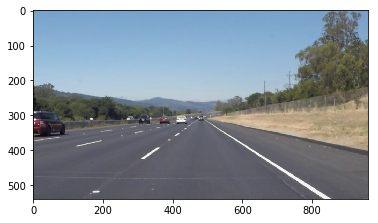

In [2]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

## Ideas for Lane Detection Pipeline

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

## Helper Functions

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [122]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=15):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    
    x_rights = []
    y_rights = []
    x_lefts = []
    y_lefts = []

    for line in lines:
        for x1, y1, x2, y2 in line:
            slope = ((y2 - y1) / (x2 - x1))
            
            if slope >= 0:  # right line
                x_rights.extend((x1, x2))
                y_rights.extend((y1, y2))
            else:  # left line
                x_lefts.extend((x1, x2))
                y_lefts.extend((y1, y2))

    max_y = img.shape[0] # total height of image
    min_y = int(max_y * 0.65) # approximate where lines should end     
    
    # Draw right line
    coefs_right = np.polyfit(x_rights, y_rights, 1)
    y1_right = min_y
    x1_right = int((y1_right - coefs_right[1]) / coefs_right[0])
    y2_right = max_y
    x2_right = int((y2_right - coefs_right[1]) / coefs_right[0])
    
    cv2.line(img, (x1_right, y1_right), (x2_right, y2_right), color, thickness)
    
    # Draw left line
    coefs_left = np.polyfit(x_lefts, y_lefts, 1)
    y1_left = max_y
    x1_left = int((y1_left - coefs_left[1]) / coefs_left[0])
    y2_left = min_y
    x2_left = int((y2_left - coefs_left[1]) / coefs_left[0])
    
    cv2.line(img, (x1_left, y1_left), (x2_left, y2_left), color, thickness)
    # print((x1_left, y1_left), (x2_left, y2_left))  
    
def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

## Test Images

Build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [123]:
import os
os.listdir("test_images/")

['solidWhiteCurve.jpg',
 'solidWhiteRight.jpg',
 'solidYellowCurve.jpg',
 'solidYellowCurve2.jpg',
 'solidYellowLeft.jpg',
 'whiteCarLaneSwitch.jpg']

## Build a Lane Finding Pipeline



Build the pipeline and run your solution on all test_images. Make copies into the `test_images_output` directory, and you can use the images in your writeup report.

Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

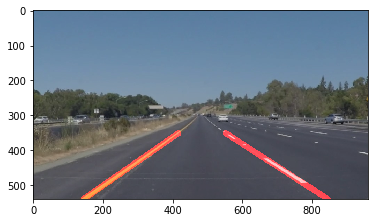

In [129]:
# TODO: Build your pipeline that will draw lane lines on the test_images
# then save them to the test_images directory.
    
def lane_lines_pipeline(image):
    # Grayscale the image
    gray = grayscale(image)

    # Gaussian smoothing
    kernel_size = 5
    blur_gray = gaussian_blur(gray, kernel_size)

    # Canny transform
    low_threshold = 50
    high_threshold = 100
    edges = canny(blur_gray, low_threshold, high_threshold)

    # Limit the edges to area where lane is
    imshape = image.shape
    vertices = np.array([[(50, imshape[0]),(400, 330), (600, 330), (imshape[1] - 50, imshape[0])]], dtype=np.int32)
    masked_edges = region_of_interest(edges, vertices)

    # Run Hough transform on our edges image
    rho = 2
    theta = np.pi/180
    threshold = 15
    min_line_len = 60
    max_line_gap = 40 
    line_image = hough_lines(masked_edges, rho, theta, threshold, min_line_len, max_line_gap)

    color_edges = np.dstack((edges, edges, edges))

    # Overlay lines onto original image
    α = 0.8 # weight of initial image
    β = 1 # weight of overlayed image
    λ = 0   
    combo = weighted_img(line_image, image, α, β, λ)

    return combo

test_images_dir = "test_images/"
# for image_name in os.listdir(test_images_dir):
# for image_name in ['solidWhiteRight.jpg']:
for image_name in ['solidYellowLeft.jpg']:
    image = mpimg.imread(test_images_dir + image_name)
    lane_lines_image = lane_lines_pipeline(image)
    # Write image to output folder
    # Image is stored in BGR so need to convert to RGB first
    cv2.imwrite('test_images_output/' + image_name, cv2.cvtColor(lane_lines_image, cv2.COLOR_BGR2RGB))
    plt.imshow(lane_lines_image)


## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an `import error` when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt. Also, check out [this forum post](https://carnd-forums.udacity.com/questions/22677062/answers/22677109) for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://carnd-forums.udacity.com/display/CAR/questions/26218840/import-videofileclip-error) for more troubleshooting tips across operating systems.**

In [125]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [126]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    result = lane_lines_pipeline(image)
    return result

Let's try the one with the solid white lane on the right first ...

In [127]:
white_output = 'test_videos_output/solidWhiteRight.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight.mp4


100%|█████████▉| 221/222 [00:04<00:00, 49.84it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight.mp4 

CPU times: user 2.61 s, sys: 306 ms, total: 2.92 s
Wall time: 5.09 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [128]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Improve the draw_lines() function

**At this point, if you were successful with making the pipeline and tuning parameters, you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform. As mentioned previously, try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines. You can see an example of the result you're going for in the video "P1_example.mp4".**

**Go back and modify your draw_lines function accordingly and try re-running your pipeline. The new output should draw a single, solid line over the left lane line and a single, solid line over the right lane line. The lines should start from the bottom of the image and extend out to the top of the region of interest.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [94]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[666, 774, 660, 759, 523, 611, 525, 604, 533, 607, 685, 755, 711, 775, 549, 611, 671, 766]
[425, 495, 428, 497, 330, 387, 332, 389, 333, 389, 446, 496, 455, 495, 350, 389, 427, 489]
[  0.67507935 -22.43389573]
 
0.6751 x - 22.43
324
540
(513, 324) (833, 540)
(540, 960, 3)
[MoviePy] >>>> Building video test_videos_output/solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft.mp4


  1%|          | 6/682 [00:00<00:11, 58.98it/s]

[666, 774, 660, 759, 523, 611, 525, 604, 533, 607, 685, 755, 711, 775, 549, 611, 671, 766]
[425, 495, 428, 497, 330, 387, 332, 389, 333, 389, 446, 496, 455, 495, 350, 389, 427, 489]
[  0.67507935 -22.43389573]
 
0.6751 x - 22.43
324
540
(513, 324) (833, 540)
(540, 960, 3)
[537, 620, 722, 811, 694, 831, 524, 622, 557, 618, 527, 617, 678, 814, 525, 614, 529, 616, 526, 587, 545, 615]
[342, 396, 471, 535, 442, 534, 330, 396, 350, 396, 330, 396, 440, 535, 332, 396, 333, 396, 330, 371, 345, 396]
[  0.69497927 -34.06228937]
 
0.695 x - 34.06
324
540
(515, 324) (826, 540)
(540, 960, 3)
[716, 839, 704, 819, 524, 634, 525, 632, 713, 839, 525, 623, 526, 628, 528, 622, 556, 625]
[458, 538, 458, 539, 330, 401, 331, 403, 457, 539, 332, 403, 330, 404, 330, 403, 353, 403]
[  0.67562119 -22.79678411]
 
0.6756 x - 22.8
324
540
(513, 324) (833, 540)
(540, 960, 3)
[749, 840, 525, 638, 748, 820, 526, 600, 538, 643, 563, 647, 760, 829, 527, 637, 738, 813, 530, 596]
[480, 539, 333, 412, 488, 538, 331, 380, 3

  2%|▏         | 14/682 [00:00<00:10, 62.65it/s]

[692, 819, 679, 784, 733, 810, 527, 621, 538, 624, 532, 624, 679, 804, 681, 749, 685, 756]
[434, 513, 433, 506, 461, 508, 330, 393, 341, 391, 332, 392, 435, 516, 432, 481, 432, 473]
[ 0.64608081 -9.31660612]
 
0.6461 x - 9.317
324
540
(515, 324) (850, 540)
(540, 960, 3)


  3%|▎         | 22/682 [00:00<00:10, 65.34it/s]

[703, 838, 524, 634, 709, 847, 713, 805, 703, 780, 534, 625, 241, 310]
[451, 538, 330, 399, 447, 530, 448, 503, 448, 500, 333, 399, 440, 440]
[  1.91010039e-01   3.20957428e+02]
 
0.191 x + 321
324
540
(15, 324) (1146, 540)
(540, 960, 3)
[734, 840, 746, 860, 524, 640, 749, 860, 529, 648, 526, 634, 525, 641, 530, 647]
[469, 538, 468, 539, 330, 408, 469, 538, 330, 408, 332, 405, 330, 408, 332, 408]
[ 0.63292055 -1.11526466]
 
0.6329 x - 1.115
324
540
(513, 324) (854, 540)
(540, 960, 3)
[529, 609, 775, 839, 788, 861, 530, 603, 775, 837, 525, 602, 534, 610, 542, 608]
[330, 384, 496, 538, 494, 538, 333, 384, 494, 536, 330, 384, 338, 382, 344, 384]
[ 0.64336381 -6.83908713]
 
0.6434 x - 6.839
324
540
(514, 324) (849, 540)
(540, 960, 3)
[526, 619, 546, 612, 527, 618, 535, 617, 526, 595]
[332, 390, 347, 390, 333, 390, 339, 390, 331, 373]
[ 0.63104482  0.47925916]
 
0.631 x + 0.4793
324
540
(512, 324) (854, 540)
(540, 960, 3)
[529, 630, 529, 619, 527, 630, 527, 622, 547, 627]
[334, 395, 330, 39

  6%|▌         | 38/682 [00:00<00:09, 71.11it/s]

[538, 613, 546, 628, 539, 622, 545, 621, 533, 601]
[332, 386, 341, 388, 332, 390, 341, 390, 330, 372]
[  0.65329794 -17.79818757]
 
0.6533 x - 17.8
324
540
(523, 324) (853, 540)
(540, 960, 3)
[530, 639, 534, 616, 541, 638, 548, 636, 539, 639]
[330, 395, 331, 388, 333, 398, 343, 398, 333, 397]
[ 0.63898451 -9.84492255]
 
0.639 x - 9.845
324
540
(522, 324) (860, 540)
(540, 960, 3)
[535, 653, 532, 646, 532, 653, 552, 642]
[330, 404, 331, 405, 330, 405, 345, 404]
[ 0.63565206 -7.77113092]
 
0.6357 x - 7.771
324
540
(521, 324) (861, 540)
(540, 960, 3)
[530, 670, 532, 650, 556, 617, 531, 670]
[330, 414, 330, 409, 348, 386, 330, 413]
[ 0.61467376  4.57644917]
 
0.6147 x + 4.576
324
540
(519, 324) (871, 540)
(540, 960, 3)
[531, 690, 565, 682, 537, 643, 555, 627, 536, 630]
[330, 425, 354, 427, 330, 398, 347, 391, 330, 391]
[ 0.62453311 -2.17005271]
 
0.6245 x - 2.17
324
540
(522, 324) (868, 540)
(540, 960, 3)
[646, 714, 638, 701, 545, 641, 532, 602, 537, 644, 562, 638]
[399, 440, 400, 441, 340,

  7%|▋         | 46/682 [00:00<00:08, 70.95it/s]

[526, 635, 532, 641, 527, 642, 573, 640, 532, 641]
[330, 401, 330, 398, 330, 402, 360, 402, 331, 402]
[ 0.63763731 -6.90461403]
 
0.6376 x - 6.905
324
540
(518, 324) (857, 540)
(540, 960, 3)
[527, 652, 531, 657, 539, 610, 577, 651]
[330, 411, 330, 408, 336, 382, 364, 410]
[ 0.63830634 -7.14066233]
 
0.6383 x - 7.141
324
540
(518, 324) (857, 540)
(540, 960, 3)
[531, 678, 527, 666, 530, 677]
[330, 422, 331, 421, 330, 422]
[ 0.63099967 -3.54629851]
 
0.631 x - 3.546
324
540
(519, 324) (861, 540)
(540, 960, 3)
[528, 686, 561, 690, 531, 631, 529, 643, 631, 700, 592, 671, 634, 700]
[332, 434, 355, 427, 330, 395, 333, 407, 398, 433, 369, 424, 395, 435]
[ 0.61334942  8.16425605]
 
0.6133 x + 8.164
324
540
(514, 324) (867, 540)
(540, 960, 3)
[529, 597, 647, 726, 640, 717, 650, 727, 529, 602, 532, 601, 529, 600, 643, 718]
[332, 376, 402, 451, 405, 451, 403, 449, 331, 373, 331, 376, 333, 376, 406, 451]
[ 0.616949    5.28314558]
 
0.6169 x + 5.283
324
540
(516, 324) (866, 540)
(540, 960, 3)
[654, 

  8%|▊         | 53/682 [00:00<00:11, 53.28it/s]

[526, 626, 708, 873, 693, 800, 783, 858, 530, 628, 530, 629, 741, 873, 700, 794, 694, 799]
[330, 392, 437, 536, 437, 502, 493, 537, 331, 392, 330, 392, 456, 535, 441, 499, 439, 502]
[ 0.61355876  7.5917371 ]
 
0.6136 x + 7.592
324
540
(515, 324) (867, 540)
(540, 960, 3)
[739, 877, 536, 635, 723, 798, 735, 828, 725, 824, 529, 597, 572, 641, 528, 636]
[456, 538, 338, 400, 455, 503, 455, 510, 455, 519, 330, 372, 362, 399, 330, 400]
[  0.60819003  11.17127043]
 
0.6082 x + 11.17
324
540
(514, 324) (869, 540)
(540, 960, 3)
[758, 855, 525, 604, 771, 876, 523, 599, 774, 872, 530, 601]
[478, 537, 330, 377, 478, 538, 330, 379, 478, 535, 331, 379]
[  0.6014379   15.44022174]
 
0.6014 x + 15.44
324
540
(513, 324) (872, 540)
(540, 960, 3)
[523, 610, 535, 612, 524, 611]
[330, 385, 333, 383, 330, 384]
[ 0.63002597 -1.0897789 ]
 
0.63 x - 1.09
324
540
(515, 324) (858, 540)
(540, 960, 3)
[524, 615, 533, 622, 528, 622, 528, 622, 524, 621]
[331, 390, 333, 388, 330, 389, 331, 390, 330, 390]
[ 0.62570861 

  9%|▊         | 59/682 [00:01<00:13, 46.35it/s]


[331, 409, 334, 414, 347, 385, 330, 415, 332, 414]
[ 0.63527784 -2.88806227]
 
0.6353 x - 2.888
324
540
(514, 324) (854, 540)
(540, 960, 3)
[526, 680, 549, 672, 754, 818, 526, 621, 527, 639, 527, 620, 526, 634]
[333, 425, 349, 426, 484, 526, 330, 392, 330, 400, 334, 392, 331, 403]
[  0.6579849  -15.44084443]
 
0.658 x - 15.44
324
540
(515, 324) (844, 540)
(540, 960, 3)
[527, 651, 553, 705, 529, 724, 594, 667, 531, 675]
[332, 415, 351, 439, 331, 462, 372, 425, 333, 430]
[  0.65014873 -11.23155698]
 
0.6501 x - 11.23
324
540
(515, 324) (847, 540)
(540, 960, 3)
[644, 762, 650, 732, 523, 601, 525, 602, 530, 601, 653, 727]
[409, 486, 407, 456, 330, 379, 330, 376, 332, 378, 408, 451]
[ 0.62722564  0.53720422]
 
0.6272 x + 0.5372
324
540
(515, 324) (860, 540)
(540, 960, 3)
[667, 771, 661, 757, 533, 606, 671, 771, 530, 610, 534, 605, 527, 608]
[417, 479, 420, 480, 338, 384, 418, 478, 333, 383, 333, 384, 330, 384]
[ 0.6149373   8.44214138]
 
0.6149 x + 8.442
324
540
(513, 324) (864, 540)
(540,

  9%|▉         | 64/682 [00:01<00:14, 42.10it/s]

[679, 803, 685, 821, 523, 618, 726, 821, 550, 615, 695, 758, 546, 616, 535, 620, 679, 757]
[432, 509, 429, 507, 330, 389, 453, 508, 344, 389, 434, 469, 347, 389, 334, 389, 430, 480]
[  0.61089238  11.25441792]
 
0.6109 x + 11.25
324
540
(511, 324) (865, 540)
(540, 960, 3)
[704, 850, 713, 862, 799, 864, 533, 631, 703, 850, 569, 630]
[448, 539, 445, 534, 495, 534, 335, 396, 446, 538, 358, 396]
[ 0.61587662  8.41220295]
 
0.6159 x + 8.412
324
540
(512, 324) (863, 540)
(540, 960, 3)
[734, 825, 522, 596, 742, 871, 521, 635, 527, 597, 739, 870, 553, 638]
[465, 524, 330, 374, 464, 538, 330, 404, 332, 374, 463, 538, 349, 404]
[  0.60982239  12.49744126]
 
0.6098 x + 12.5
324
540
(510, 324) (865, 540)
(540, 960, 3)
[773, 848, 789, 868, 522, 604, 774, 849, 525, 599, 521, 601, 543, 605, 522, 603, 788, 869]
[491, 539, 491, 538, 331, 380, 492, 538, 330, 382, 330, 382, 342, 380, 330, 382, 491, 538]
[ 0.61757338  8.37511273]
 
0.6176 x + 8.375
324
540
(511, 324) (860, 540)
(540, 960, 3)
[526, 611, 52

 10%|█         | 69/682 [00:01<00:15, 40.30it/s]

[528, 624, 522, 617, 536, 623, 522, 624, 542, 614, 527, 621, 540, 620]
[332, 392, 330, 394, 338, 394, 331, 393, 346, 393, 333, 394, 344, 394]
[ 0.63867607 -2.83779258]
 
0.6387 x - 2.838
324
540
(511, 324) (849, 540)
(540, 960, 3)
[543, 628, 523, 635, 523, 635, 533, 632, 526, 625]
[346, 401, 330, 400, 331, 401, 339, 401, 330, 400]
[ 0.64505774 -6.42700611]
 
0.6451 x - 6.427
324
540
(512, 324) (847, 540)
(540, 960, 3)
[524, 642, 527, 649, 737, 821, 524, 640, 549, 639]
[330, 409, 330, 409, 474, 528, 331, 409, 346, 402]
[  0.66930599 -21.65010519]
 
0.6693 x - 21.65
324
540
(516, 324) (839, 540)
(540, 960, 3)
[525, 666, 521, 582, 547, 611, 582, 655, 575, 659]
[334, 419, 330, 366, 349, 389, 367, 412, 368, 420]
[ 0.61765275  9.56427381]
 
0.6177 x + 9.564
324
540
(509, 324) (858, 540)
(540, 960, 3)
[581, 677, 551, 686, 524, 584, 521, 588, 550, 680, 583, 657]
[372, 432, 352, 430, 330, 372, 330, 369, 351, 426, 369, 421]
[ 0.62282781  6.73755346]
 
0.6228 x + 6.738
324
540
(509, 324) (856, 54

 11%|█         | 74/682 [00:01<00:15, 40.43it/s]

[650, 742, 645, 727, 652, 730, 645, 729, 522, 593, 526, 597, 531, 594]
[412, 465, 414, 467, 412, 457, 412, 467, 331, 381, 330, 381, 334, 381]
[ 0.63531605  0.0348212 ]
 
0.6353 x + 0.03482
324
540
(509, 324) (849, 540)
(540, 960, 3)
[670, 783, 526, 608, 662, 768, 521, 606, 519, 604, 673, 769, 549, 609]
[424, 492, 331, 386, 424, 493, 330, 387, 330, 387, 425, 481, 347, 386]
[ 0.62830034  3.70434761]
 
0.6283 x + 3.704
324
540
(509, 324) (853, 540)
(540, 960, 3)


 12%|█▏        | 79/682 [00:01<00:15, 39.42it/s]

[691, 835, 681, 747, 518, 614, 758, 820, 683, 756, 693, 765, 526, 619, 763, 839, 548, 619]
[437, 523, 438, 481, 330, 392, 486, 527, 437, 486, 437, 479, 332, 392, 478, 525, 347, 390]
[ 0.62969799  3.41764354]
 
0.6297 x + 3.418
324
540
(509, 324) (852, 540)
(540, 960, 3)
[720, 861, 706, 841, 526, 630, 527, 629, 519, 622, 520, 587]
[453, 538, 454, 538, 335, 398, 332, 398, 330, 399, 330, 375]
[ 0.62809985  4.26402759]
 
0.6281 x + 4.264
324
540
(509, 324) (852, 540)
(540, 960, 3)
[519, 634, 737, 839, 753, 861, 524, 640, 569, 634, 529, 598, 522, 596, 552, 633]
[330, 404, 475, 537, 474, 538, 331, 406, 365, 407, 333, 377, 331, 379, 353, 405]
[ 0.63081882  3.03107194]
 
0.6308 x + 3.031
324
540
(508, 324) (851, 540)
(540, 960, 3)
[528, 606, 799, 860, 537, 600, 780, 840, 521, 590, 525, 604, 522, 602]
[336, 383, 502, 539, 343, 384, 502, 538, 330, 372, 330, 381, 332, 384]
[ 0.63337577  0.72060117]
 
0.6334 x + 0.7206
324
540
(510, 324) (851, 540)
(540, 960, 3)
[526, 615, 521, 607, 525, 608, 519,

 12%|█▏        | 84/682 [00:01<00:17, 35.13it/s]

[521, 643, 528, 651, 525, 641, 524, 603, 526, 602]
[330, 412, 331, 411, 334, 412, 331, 382, 331, 382]
[  0.66346913 -16.82360682]
 
0.6635 x - 16.82
324
540
(513, 324) (839, 540)
(540, 960, 3)
[546, 662, 525, 668, 520, 609, 546, 659, 527, 610]
[349, 424, 332, 421, 330, 388, 348, 416, 332, 388]
[ 0.63473644  0.08276124]
 
0.6347 x + 0.08276
324
540
(510, 324) (850, 540)
(540, 960, 3)
[521, 688, 618, 680, 550, 619, 524, 588, 619, 683, 526, 621]

 13%|█▎        | 88/682 [00:01<00:16, 35.77it/s]


[330, 434, 397, 437, 352, 395, 330, 370, 397, 437, 335, 394]
[ 0.65117773 -8.71443738]
 
0.6512 x - 8.714
324
540
(510, 324) (842, 540)
(540, 960, 3)
[532, 690, 521, 594, 525, 594, 634, 700, 628, 708]
[334, 444, 330, 376, 330, 375, 402, 440, 403, 453]
[  0.66030112 -15.80046874]
 
0.6603 x - 15.8
324
540
(514, 324) (841, 540)
(540, 960, 3)
[649, 751, 641, 737, 642, 740, 522, 595, 526, 597, 521, 602, 529, 602]
[411, 472, 412, 474, 411, 474, 332, 378, 330, 381, 331, 378, 336, 380]
[ 0.64765125 -7.48385373]
 
0.6477 x - 7.484
324
540
(511, 324) (845, 540)
(540, 960, 3)
[658, 781, 671, 796, 519, 606, 525, 608, 527, 610, 722, 795, 521, 607]
[422, 502, 422, 500, 330, 386, 331, 385, 331, 385, 454, 501, 330, 386]
[ 0.6331859   0.03706729]
 
0.6332 x + 0.03707
324
540
(511, 324) (852, 540)
(540, 960, 3)
[691, 766, 678, 835, 783, 843, 518, 619, 744, 836, 524, 617, 689, 754, 523, 619, 685, 751, 536, 619]
[436, 481, 435, 537, 492, 530, 330, 390, 480, 538, 334, 392, 436, 474, 331, 389, 440, 484, 3

 13%|█▎        | 92/682 [00:01<00:17, 33.11it/s]


[330, 400, 452, 538, 454, 538, 453, 539, 332, 399, 330, 400, 332, 374, 454, 513, 344, 400]
[ 0.63872428 -1.11646483]
 
0.6387 x - 1.116
324
540
(509, 324) (847, 540)
(540, 960, 3)
[756, 855, 734, 795, 735, 834, 520, 595, 531, 630, 523, 638, 520, 587, 736, 796, 522, 595, 737, 815, 522, 640]
[477, 539, 475, 515, 474, 538, 331, 378, 339, 408, 331, 409, 332, 379, 473, 515, 330, 377, 473, 527, 335, 409]
[ 0.65120002 -6.99725175]
 
0.6512 x - 6.997
324
540
(508, 324) (839, 540)
(540, 960, 3)
[521, 599, 524, 600, 521, 600, 522, 602]
[335, 386, 332, 383, 333, 386, 332, 386]
[  0.66688083 -15.07850696]
 
0.6669 x - 15.08
324
540
(508, 324) (832, 540)
(540, 960, 3)
[513, 605, 524, 612, 522, 610, 522, 611, 524, 604]
[330, 392, 333, 390, 335, 392, 334, 392, 338, 392]
[ 0.65614716 -7.72629861]
 
0.6561 x - 7.726
324
540
(505, 324) (834, 540)
(540, 960, 3)
[514, 617, 529, 622, 516, 587, 533, 622]
[330, 399, 338, 398, 330, 378, 341, 397]
[ 0.64992924 -4.95984196]
 
0.6499 x - 4.96
324
540
(506, 324)

 14%|█▍        | 96/682 [00:02<00:18, 31.12it/s]

[517, 634, 513, 624, 514, 630, 515, 630, 527, 629]
[331, 404, 330, 405, 330, 402, 331, 406, 335, 406]
[ 0.64997267 -4.62933265]
 
0.65 x - 4.629
324
540
(505, 324) (837, 540)
(540, 960, 3)
[527, 647, 515, 640, 518, 643, 530, 614, 527, 647, 525, 641]
[339, 411, 330, 414, 330, 414, 336, 392, 335, 413, 336, 414]
[ 0.65465825 -8.46555445]
 
0.6547 x - 8.466
324
540
(507, 324) (837, 540)
(540, 960, 3)
[548, 657, 517, 663, 515, 654, 527, 612, 519, 663]
[353, 424, 330, 421, 330, 423, 335, 392, 330, 420]
[ 0.64482696 -3.03583983]
 
0.6448 x - 3.036
324
540
(507, 324) (842, 540)
(540, 960, 3)
[517, 683, 531, 677, 530, 670, 519, 684, 517, 620]
[330, 433, 341, 436, 336, 434, 330, 433, 331, 398]
[ 0.64388128 -2.78058269]
 
0.6439 x - 2.781
324
540
(507, 324) (842, 540)
(540, 960, 3)
[518, 698, 640, 708, 644, 708, 641, 709, 517, 597, 555, 633, 555, 633]

 15%|█▍        | 101/682 [00:02<00:18, 32.16it/s]


[330, 451, 406, 450, 407, 447, 406, 448, 330, 378, 356, 405, 354, 406]
[ 0.62784411  5.4712113 ]
 
0.6278 x + 5.471
324
540
(507, 324) (851, 540)
(540, 960, 3)
[646, 726, 658, 738, 653, 741, 523, 605, 646, 728, 527, 605, 669, 741]
[416, 470, 416, 466, 415, 468, 335, 383, 415, 470, 335, 382, 425, 470]
[ 0.63933995 -1.41168402]
 
0.6393 x - 1.412
324
540
(508, 324) (846, 540)
(540, 960, 3)
[522, 614, 669, 782, 663, 768, 673, 778, 518, 611, 517, 609, 523, 608]
[330, 388, 425, 493, 428, 496, 426, 489, 330, 390, 330, 390, 330, 387]
[ 0.63493579  0.68883022]
 
0.6349 x + 0.6888
324
540
(509, 324) (849, 540)
(540, 960, 3)
[683, 822, 689, 839, 518, 618, 523, 624, 690, 773, 518, 620, 686, 751, 533, 624]
[441, 531, 438, 528, 331, 396, 330, 395, 438, 486, 330, 396, 438, 474, 339, 394]
[ 0.63332896  1.75495779]
 
0.6333 x + 1.755
324
540
(508, 324) (849, 540)
(540, 960, 3)


 15%|█▌        | 105/682 [00:02<00:17, 32.27it/s]

[708, 832, 520, 635, 720, 828, 520, 587, 763, 829, 523, 632, 522, 629, 768, 833, 716, 801]
[456, 539, 330, 402, 456, 521, 332, 377, 483, 522, 330, 403, 333, 400, 497, 538, 455, 506]
[ 0.64065049 -2.34910756]
 
0.6407 x - 2.349
324
540
(509, 324) (846, 540)
(540, 960, 3)
[753, 855, 742, 833, 523, 599, 766, 844, 517, 592, 521, 597, 539, 642]
[476, 539, 477, 539, 330, 379, 482, 532, 330, 380, 330, 381, 341, 411]
[ 0.63479568  0.62856295]
 
0.6348 x + 0.6286
324
540
(509, 324) (849, 540)
(540, 960, 3)
[522, 607, 540, 601, 523, 607, 526, 594]
[331, 384, 346, 386, 333, 386, 331, 377]
[ 0.64697129 -6.28877801]
 
0.647 x - 6.289
324
540
(510, 324) (844, 540)
(540, 960, 3)
[532, 611, 532, 616, 522, 607, 523, 616, 526, 615, 524, 601]
[339, 392, 338, 391, 334, 391, 331, 389, 336, 392, 334, 380]
[ 0.63632803  0.33843265]
 
0.6363 x + 0.3384
324
540
(508, 324) (848, 540)
(540, 960, 3)


 16%|█▌        | 109/682 [00:02<00:17, 33.42it/s]

[529, 621, 524, 627, 546, 620, 523, 627, 530, 624, 542, 623, 526, 625]
[337, 399, 333, 397, 351, 399, 334, 399, 337, 396, 348, 399, 337, 399]
[ 0.63623391  1.41259902]
 
0.6362 x + 1.413
324
540
(507, 324) (846, 540)
(540, 960, 3)
[520, 640, 523, 635, 553, 634, 521, 597, 517, 597, 551, 635]
[333, 405, 331, 407, 356, 407, 332, 383, 330, 382, 354, 403]
[ 0.63558034  1.90644113]
 
0.6356 x + 1.906
324
540
(506, 324) (846, 540)
(540, 960, 3)
[526, 648, 517, 654, 519, 654, 516, 605]
[338, 417, 330, 415, 330, 414, 330, 388]
[ 0.63037015  4.71410832]
 
0.6304 x + 4.714
324
540
(506, 324) (849, 540)
(540, 960, 3)


 17%|█▋        | 113/682 [00:02<00:16, 33.82it/s]

[517, 672, 529, 664, 523, 672, 518, 616, 516, 585]
[330, 426, 340, 428, 332, 425, 331, 394, 330, 375]
[ 0.63075615  4.50452501]
 
0.6308 x + 4.505
324
540
(506, 324) (848, 540)
(540, 960, 3)
[528, 685, 591, 693, 517, 627, 634, 694, 526, 629, 516, 592]
[339, 441, 375, 441, 330, 401, 402, 439, 335, 401, 330, 379]
[ 0.63092603  4.17858057]
 
0.6309 x + 4.179
324
540
(506, 324) (849, 540)
(540, 960, 3)
[645, 721, 518, 709, 522, 639, 517, 592, 522, 678]
[409, 456, 330, 458, 330, 409, 330, 382, 331, 437]
[ 0.65068726 -7.31168294]
 
0.6507 x - 7.312
324
540
(509, 324) (841, 540)
(540, 960, 3)
[653, 741, 662, 758, 518, 605, 522, 610, 536, 606, 547, 609, 660, 738]
[419, 479, 419, 479, 330, 388, 330, 387, 344, 388, 348, 387, 419, 467]
[ 0.6357242   0.84838696]
 
0.6357 x + 0.8484
324
540
(508, 324) (848, 540)
(540, 960, 3)


 17%|█▋        | 117/682 [00:02<00:15, 35.36it/s]

[672, 788, 683, 754, 723, 803, 520, 610, 518, 620, 674, 752, 525, 615, 553, 616]
[433, 508, 431, 474, 457, 504, 332, 393, 330, 392, 430, 473, 330, 393, 349, 390]
[ 0.62885512  3.90978516]
 
0.6289 x + 3.91
324
540
(509, 324) (852, 540)
(540, 960, 3)
[717, 856, 694, 836, 705, 849, 522, 631, 524, 624, 536, 627, 529, 620, 525, 629]
[451, 537, 447, 539, 445, 534, 333, 399, 330, 400, 343, 400, 338, 399, 330, 400]
[ 0.6287266   4.44712093]
 
0.6287 x + 4.447
324
540
(508, 324) (851, 540)
(540, 960, 3)
[750, 856, 723, 836, 522, 645, 522, 632, 520, 638, 525, 640]
[471, 537, 466, 539, 331, 407, 333, 407, 331, 408, 330, 408]
[ 0.63611502  0.04814989]
 
0.6361 x + 0.04815
324
540
(509, 324) (848, 540)
(540, 960, 3)
[531, 601, 520, 605, 771, 860, 761, 838, 775, 850, 519, 606, 528, 606, 522, 605]
[339, 385, 330, 383, 487, 538, 490, 538, 488, 534, 330, 385, 332, 383, 333, 385]
[ 0.62740864  4.59150476]
 
0.6274 x + 4.592
324
540
(509, 324) (853, 540)
(540, 960, 3)


 18%|█▊        | 121/682 [00:02<00:16, 34.85it/s]

[522, 607, 525, 610, 526, 614, 524, 615, 541, 615, 525, 596]
[331, 390, 332, 391, 331, 390, 334, 389, 346, 390, 334, 377]
[ 0.64726389 -6.61164327]
 
0.6473 x - 6.612
324
540
(510, 324) (844, 540)
(540, 960, 3)
[520, 626, 545, 619, 544, 626, 524, 623, 520, 620]
[331, 395, 349, 397, 348, 397, 330, 397, 330, 397]
[ 0.64224309 -3.28158869]
 
0.6422 x - 3.282
324
540
(509, 324) (845, 540)
(540, 960, 3)
[526, 638, 569, 629, 545, 635, 545, 636, 527, 636]
[333, 403, 365, 404, 349, 405, 348, 405, 333, 401]
[ 0.6333074   1.83526686]
 
0.6333 x + 1.835
324
540
(508, 324) (849, 540)
(540, 960, 3)
[527, 652, 548, 646, 519, 581, 539, 652]
[336, 411, 351, 414, 330, 366, 344, 412]
[ 0.6187207   9.78583389]
 
0.6187 x + 9.786
324
540
(507, 324) (856, 540)
(540, 960, 3)
[520, 670, 551, 660, 522, 665, 519, 581, 528, 616]
[330, 424, 353, 424, 330, 419, 330, 369, 337, 392]
[ 0.63202296  2.20421216]
 
0.632 x + 2.204
324
540
(509, 324) (850, 540)
(540, 960, 3)


 18%|█▊        | 126/682 [00:02<00:14, 38.13it/s]

[519, 688, 530, 683, 524, 626, 591, 653, 532, 677]
[330, 435, 339, 438, 330, 399, 373, 413, 339, 436]
[ 0.64668964 -6.30117054]
 
0.6467 x - 6.301
324
540
(510, 324) (844, 540)
(540, 960, 3)
[643, 717, 636, 706, 520, 639, 524, 596, 521, 594, 648, 718]
[406, 452, 408, 453, 330, 407, 331, 377, 331, 380, 408, 451]
[ 0.62954531  3.02773999]
 
0.6295 x + 3.028
324
540
(509, 324) (852, 540)
(540, 960, 3)
[522, 607, 658, 751, 650, 737, 521, 605, 520, 606, 529, 607]
[330, 383, 416, 472, 418, 474, 331, 385, 331, 385, 332, 385]
[ 0.64294597 -4.98865613]
 
0.6429 x - 4.989
324
540
(511, 324) (847, 540)
(540, 960, 3)
[667, 781, 676, 795, 520, 615, 541, 613, 678, 739, 535, 608, 523, 611, 689, 781]
[428, 502, 428, 499, 331, 388, 341, 391, 428, 463, 342, 391, 331, 388, 435, 489]
[ 0.621252    8.21088979]
 
0.6213 x + 8.211
324
540
(508, 324) (855, 540)
(540, 960, 3)
[519, 622, 688, 839, 523, 626, 699, 780, 772, 856, 688, 749, 760, 836, 526, 621, 757, 851]
[331, 398, 444, 538, 332, 396, 442, 489, 485,

 19%|█▉        | 130/682 [00:03<00:15, 36.12it/s]

(540, 960, 3)
[729, 860, 520, 632, 715, 839, 572, 634, 524, 595, 728, 858, 518, 638, 571, 636, 527, 595]
[460, 538, 332, 405, 461, 538, 368, 405, 332, 378, 460, 538, 330, 402, 367, 405, 332, 379]
[ 0.62198083  8.80122881]
 
0.622 x + 8.801
324
540
(506, 324) (854, 540)
(540, 960, 3)
[749, 839, 766, 860, 525, 603, 522, 594, 521, 602, 756, 829, 524, 643, 768, 828, 518, 585]
[482, 538, 482, 538, 332, 381, 333, 382, 332, 383, 485, 531, 330, 413, 482, 517, 330, 371]
[ 0.62893003  4.1507723 ]
 
0.6289 x + 4.151
324
540
(508, 324) (852, 540)
(540, 960, 3)


 20%|█▉        | 134/682 [00:03<00:15, 36.10it/s]

[517, 606, 537, 611, 518, 608, 541, 604, 523, 609, 520, 583]
[330, 388, 338, 388, 330, 388, 347, 388, 330, 388, 330, 371]
[  0.65742014 -11.61135777]
 
0.6574 x - 11.61
324
540
(510, 324) (839, 540)
(540, 960, 3)
[520, 620, 526, 614, 543, 618, 518, 615, 524, 617]
[331, 391, 335, 394, 348, 390, 331, 394, 331, 394]
[ 0.63389296  1.63017219]
 
0.6339 x + 1.63
324
540
(508, 324) (849, 540)
(540, 960, 3)
[521, 631, 527, 624, 518, 595, 529, 629]
[331, 399, 337, 400, 331, 379, 334, 401]
[ 0.63869584 -1.17434831]
 
0.6387 x - 1.174
324
540
(509, 324) (847, 540)
(540, 960, 3)
[522, 644, 517, 639, 522, 642, 547, 644, 518, 579]
[330, 406, 330, 409, 331, 409, 351, 407, 330, 366]
[ 0.62815794  4.20160616]
 
0.6282 x + 4.202
324
540
(509, 324) (852, 540)
(540, 960, 3)
[518, 652, 522, 660, 522, 610, 530, 612, 517, 611, 523, 584]
[331, 418, 330, 416, 332, 389, 336, 389, 330, 389, 330, 368]
[ 0.63785678 -1.52794731]
 
0.6379 x - 1.528
324
540
(510, 324) (848, 540)
(540, 960, 3)
[532, 667, 520, 676, 516

 20%|██        | 138/682 [00:03<00:14, 36.87it/s]

[341, 422, 330, 427, 330, 409, 333, 396, 330, 396, 342, 427]
[  0.61877218  10.26093416]
 
0.6188 x + 10.26
324
540
(507, 324) (856, 540)
(540, 960, 3)
[518, 701, 522, 690, 589, 687, 516, 597, 566, 631]
[332, 442, 331, 444, 377, 443, 330, 377, 364, 403]
[ 0.63994903 -0.75733284]
 
0.6399 x - 0.7573
324
540
(507, 324) (845, 540)
(540, 960, 3)
[643, 717, 648, 727, 521, 603, 649, 723, 516, 602, 601, 662, 524, 598]
[411, 461, 411, 458, 331, 380, 411, 454, 330, 383, 380, 426, 331, 383]
[ 0.6316579   2.36427567]
 
0.6317 x + 2.364
324
540
(509, 324) (851, 540)
(540, 960, 3)
[659, 750, 666, 766, 523, 611, 523, 604, 659, 748, 669, 759, 516, 609, 658, 753, 530, 608]
[424, 483, 421, 481, 331, 388, 334, 388, 421, 481, 422, 476, 330, 388, 424, 483, 335, 385]
[ 0.63650481  0.25237185]
 
0.6365 x + 0.2524
324
540
(508, 324) (847, 540)
(540, 960, 3)


 21%|██        | 142/682 [00:03<00:14, 37.14it/s]

[517, 616, 690, 813, 555, 616, 677, 802, 698, 803, 688, 816, 532, 613, 533, 621]
[330, 394, 434, 510, 350, 391, 436, 514, 451, 514, 434, 513, 336, 393, 336, 393]
[ 0.63496757  0.29334033]
 
0.635 x + 0.2933
324
540
(509, 324) (849, 540)
(540, 960, 3)
[713, 862, 701, 838, 521, 629, 523, 624, 786, 861, 755, 817, 515, 631, 568, 628, 721, 803]
[449, 538, 450, 539, 330, 400, 333, 401, 494, 538, 484, 525, 330, 397, 365, 397, 454, 502]
[ 0.62019369  9.78109394]
 
0.6202 x + 9.781
324
540
(506, 324) (854, 540)
(540, 960, 3)
[515, 596, 748, 855, 731, 831, 521, 598, 517, 598, 513, 640, 772, 833, 800, 860]
[330, 378, 470, 536, 470, 533, 330, 378, 330, 379, 330, 409, 498, 535, 501, 538]
[ 0.62629731  6.30143934]
 
0.6263 x + 6.301
324
540
(507, 324) (852, 540)
(540, 960, 3)
[785, 862, 526, 605, 771, 831, 528, 606, 518, 601, 771, 833, 771, 837, 515, 603, 788, 863]
[493, 539, 334, 385, 493, 533, 334, 385, 331, 385, 494, 538, 495, 538, 330, 385, 494, 538]
[ 0.62957596  4.58493693]
 
0.6296 x + 4.585


 21%|██▏       | 146/682 [00:03<00:14, 37.35it/s]

[520, 625, 516, 625, 514, 622, 527, 591]
[330, 395, 330, 396, 330, 397, 336, 377]
[  0.6162642   11.64506804]
 
0.6163 x + 11.65
324
540
(506, 324) (857, 540)
(540, 960, 3)
[516, 629, 516, 637, 532, 632, 524, 637, 519, 633]
[331, 404, 330, 402, 337, 404, 335, 403, 330, 404]
[ 0.62868859  4.93233972]
 
0.6287 x + 4.932
324
540
(507, 324) (851, 540)
(540, 960, 3)
[526, 652, 521, 644, 522, 607, 519, 648]
[333, 411, 333, 413, 331, 386, 330, 413]
[ 0.63815863 -1.30223325]
 
0.6382 x - 1.302
324
540
(509, 324) (848, 540)
(540, 960, 3)


 22%|██▏       | 150/682 [00:03<00:14, 36.86it/s]

[518, 659, 544, 669, 518, 614, 520, 615, 534, 616, 514, 585]
[331, 423, 344, 422, 330, 392, 330, 391, 338, 391, 331, 373]
[ 0.63121302  3.0702393 ]
 
0.6312 x + 3.07
324
540
(508, 324) (850, 540)
(540, 960, 3)
[520, 686, 519, 680, 519, 687, 588, 690, 587, 672, 547, 640]
[331, 431, 332, 436, 333, 433, 377, 434, 374, 423, 346, 411]
[  0.6112106   14.81418493]
 
0.6112 x + 14.81
324
540
(505, 324) (859, 540)
(540, 960, 3)
[523, 703, 644, 716, 524, 715, 522, 705, 513, 640]
[335, 451, 406, 449, 332, 451, 332, 451, 330, 406]
[ 0.6218145   8.46410525]
 
0.6218 x + 8.464
324
540
(507, 324) (854, 540)
(540, 960, 3)
[659, 749, 651, 733, 525, 604, 651, 739, 525, 608, 511, 605, 652, 734]
[416, 470, 418, 471, 335, 386, 417, 472, 333, 386, 330, 386, 416, 471]
[ 0.63181797  3.91117322]
 
0.6318 x + 3.911
324
540
(506, 324) (848, 540)
(540, 960, 3)
[668, 775, 677, 792, 512, 618, 513, 616, 518, 619, 265, 331, 680, 792, 525, 613]
[428, 497, 427, 496, 330, 391, 331, 392, 330, 389, 428, 428, 428, 495, 333

 23%|██▎       | 155/682 [00:03<00:13, 38.52it/s]


[440, 532, 442, 533, 331, 373, 330, 397, 441, 488, 333, 398, 330, 367, 338, 398]
[  0.61352962  13.27402236]
 
0.6135 x + 13.27
324
540
(506, 324) (858, 540)
(540, 960, 3)
[728, 864, 718, 842, 517, 592, 512, 642, 528, 594, 562, 638, 719, 843, 544, 640, 545, 640]
[457, 538, 459, 537, 330, 379, 330, 405, 335, 379, 355, 402, 461, 539, 345, 405, 345, 402]
[ 0.62727358  4.66510081]
 
0.6273 x + 4.665
324
540
(509, 324) (853, 540)
(540, 960, 3)
[764, 865, 753, 843, 515, 606, 767, 836, 513, 597, 777, 864, 525, 605, 753, 844, 529, 607, 518, 580]
[479, 539, 482, 538, 330, 382, 480, 520, 331, 383, 484, 538, 336, 384, 481, 538, 336, 384, 333, 370]
[  0.60908778  16.36259135]
 
0.6091 x + 16.36
324
540
(505, 324) (859, 540)
(540, 960, 3)
[510, 604, 530, 611, 538, 615, 513, 608, 517, 615, 518, 591, 536, 614]
[330, 388, 338, 390, 342, 388, 331, 390, 331, 389, 332, 379, 343, 390]
[  0.60828364  17.38525383]
 
0.6083 x + 17.39
324
540
(504, 324) (859, 540)
(540, 960, 3)
[509, 625, 532, 617, 533, 624,

 23%|██▎       | 159/682 [00:03<00:13, 38.63it/s]


(502, 324) (865, 540)
(540, 960, 3)
[513, 636, 508, 632, 514, 637, 509, 633]
[330, 401, 330, 404, 330, 401, 330, 404]
[  0.58582535  30.71852852]
 
0.5858 x + 30.72
324
540
(500, 324) (869, 540)
(540, 960, 3)
[514, 650, 508, 645, 534, 607, 565, 647, 514, 646, 545, 649]
[332, 410, 330, 412, 341, 388, 359, 412, 330, 412, 347, 409]
[  0.60129618  21.54130046]
 
0.6013 x + 21.54
324
540
(503, 324) (862, 540)
(540, 960, 3)
[518, 656, 506, 666, 535, 618, 519, 659]
[332, 421, 330, 419, 342, 393, 335, 422]
[  0.60488436  20.6194815 ]
 
0.6049 x + 20.62
324
540
(501, 324) (858, 540)
(540, 960, 3)
[520, 687, 508, 680, 517, 652, 549, 631]
[335, 432, 330, 433, 331, 418, 349, 400]
[  0.60400038  20.3277719 ]
 
0.604 x + 20.33
324
540
(502, 324) (860, 540)
(540, 960, 3)


 24%|██▍       | 163/682 [00:03<00:14, 36.80it/s]

[642, 710, 521, 701, 508, 603, 514, 604]
[406, 445, 335, 447, 330, 380, 330, 382]
[  0.5946406   24.86764957]
 
0.5946 x + 24.87
324
540
(503, 324) (866, 540)
(540, 960, 3)
[657, 741, 516, 611, 513, 577, 652, 731, 509, 611, 515, 612, 514, 609]
[414, 462, 330, 384, 330, 370, 417, 464, 330, 386, 330, 386, 333, 387]
[  0.59306209  25.7326026 ]
 
0.5931 x + 25.73
324
540
(502, 324) (867, 540)
(540, 960, 3)
[667, 766, 676, 780, 677, 737, 511, 620, 540, 615, 516, 578, 519, 620, 514, 613, 670, 757, 704, 781]
[424, 486, 424, 484, 424, 457, 331, 389, 343, 391, 330, 370, 331, 391, 330, 391, 424, 480, 438, 484]
[  0.59135746  25.82758771]
 
0.5914 x + 25.83
324
540
(504, 324) (869, 540)
(540, 960, 3)
[517, 631, 695, 825, 689, 820, 523, 627, 688, 818, 698, 774, 514, 589, 697, 781, 510, 631]
[330, 396, 436, 508, 438, 516, 335, 397, 438, 516, 436, 478, 330, 376, 436, 484, 330, 394]
[  0.59064917  26.12568786]
 
0.5906 x + 26.13
324
540
(504, 324) (870, 540)
(540, 960, 3)


 24%|██▍       | 167/682 [00:04<00:13, 37.70it/s]

[723, 875, 537, 639, 714, 856, 517, 593, 511, 642, 519, 643, 769, 872, 515, 636, 513, 578]
[451, 538, 340, 403, 453, 538, 330, 379, 330, 403, 330, 401, 475, 536, 330, 403, 330, 366]
[  0.58737138  27.33048177]
 
0.5874 x + 27.33
324
540
(505, 324) (872, 540)
(540, 960, 3)
[759, 878, 746, 856, 516, 604, 519, 607, 537, 607, 513, 601, 518, 651, 810, 875]
[470, 538, 471, 537, 330, 383, 331, 380, 340, 382, 331, 382, 330, 410, 500, 536]
[  0.58535109  28.00215479]
 
0.5854 x + 28
324
540
(505, 324) (874, 540)
(540, 960, 3)
[519, 616, 802, 877, 788, 857, 513, 614, 518, 615, 799, 880, 552, 615]
[330, 386, 495, 538, 497, 539, 330, 388, 330, 388, 494, 538, 348, 387]
[  0.58953745  24.93387993]
 
0.5895 x + 24.93
324
540
(507, 324) (873, 540)
(540, 960, 3)
[512, 622, 519, 625, 517, 625, 518, 626]

 25%|██▌       | 171/682 [00:04<00:13, 36.96it/s]


[330, 393, 330, 391, 331, 393, 330, 393]
[  0.57543011  33.09212103]
 
0.5754 x + 33.09
324
540
(505, 324) (880, 540)
(540, 960, 3)
[516, 632, 519, 636, 518, 637, 521, 633]
[331, 400, 330, 397, 331, 399, 333, 400]
[  0.58330859  28.84759855]
 
0.5833 x + 28.85
324
540
(505, 324) (876, 540)
(540, 960, 3)
[522, 649, 518, 644, 521, 647, 546, 648, 522, 646, 580, 650]
[331, 404, 331, 407, 331, 406, 344, 403, 333, 407, 367, 406]
[  0.58618073  26.01834065]
 
0.5862 x + 26.02
324
540
(508, 324) (876, 540)
(540, 960, 3)
[518, 617, 520, 664, 560, 630, 517, 587, 531, 591]
[333, 388, 331, 411, 352, 399, 331, 371, 338, 371]
[  0.56695397  37.35189762]
 
0.567 x + 37.35
324
540
(505, 324) (886, 540)
(540, 960, 3)
[521, 682, 513, 680, 550, 674, 597, 684, 530, 627, 562, 630, 524, 673]
[332, 421, 330, 426, 346, 426, 372, 424, 336, 394, 353, 394, 334, 424]
[  0.58538027  26.23520263]
 
0.5854 x + 26.24
324
540
(508, 324) (877, 540)
(540, 960, 3)


 26%|██▌       | 176/682 [00:04<00:13, 38.56it/s]

[525, 704, 525, 699, 640, 706, 600, 706, 571, 639, 522, 648]
[333, 433, 334, 438, 400, 435, 374, 437, 362, 400, 331, 407]
[  0.57369587  32.49053395]
 
0.5737 x + 32.49
324
540
(508, 324) (884, 540)
(540, 960, 3)
[657, 731, 516, 607, 578, 721, 607, 722, 526, 611, 532, 611, 513, 606, 541, 605, 543, 604]
[408, 447, 330, 382, 361, 453, 378, 453, 332, 379, 338, 380, 330, 382, 341, 379, 343, 379]
[  0.58327935  26.52785594]
 
0.5833 x + 26.53
324
540
(509, 324) (880, 540)
(540, 960, 3)
[672, 770, 667, 757, 533, 617, 681, 764, 516, 613, 556, 619, 531, 615, 693, 759]
[417, 471, 419, 473, 336, 386, 421, 465, 330, 386, 349, 386, 337, 386, 434, 473]
[  0.57907575  29.25237604]
 
0.5791 x + 29.25
324
540
(508, 324) (882, 540)
(540, 960, 3)


 27%|██▋       | 181/682 [00:04<00:12, 39.01it/s]

[694, 818, 687, 806, 514, 626, 526, 630, 523, 625, 533, 629, 710, 777]
[428, 497, 431, 500, 330, 392, 333, 390, 333, 392, 337, 392, 444, 484]
[  0.58066473  28.57945172]
 
0.5807 x + 28.58
324
540
(508, 324) (880, 540)
(540, 960, 3)
[711, 866, 718, 884, 785, 884, 519, 634, 520, 641, 513, 632, 540, 638, 796, 871, 524, 641]
[444, 537, 442, 534, 480, 535, 330, 396, 330, 397, 330, 398, 346, 398, 486, 525, 334, 396]
[  0.56262659  39.34046276]
 
0.5626 x + 39.34
324
540
(505, 324) (889, 540)
(540, 960, 3)
[741, 869, 751, 875, 514, 654, 788, 848, 522, 603, 519, 601, 814, 889, 742, 803, 527, 645, 513, 647]
[462, 539, 460, 529, 331, 405, 489, 526, 331, 377, 331, 380, 496, 538, 460, 499, 335, 403, 331, 403]
[  0.57352885  33.65112752]
 
0.5735 x + 33.65
324
540
(506, 324) (882, 540)
(540, 960, 3)
[780, 871, 795, 892, 540, 615, 519, 615, 518, 612, 523, 615, 805, 891, 510, 609, 544, 615, 530, 613, 780, 869]
[485, 538, 484, 538, 341, 384, 333, 386, 330, 386, 332, 383, 490, 539, 330, 385, 348, 385,

 27%|██▋       | 185/682 [00:04<00:13, 38.01it/s]


(506, 324) (897, 540)
(540, 960, 3)
[518, 649, 534, 647, 557, 645, 531, 648, 520, 583, 513, 580]
[331, 401, 341, 403, 356, 403, 341, 401, 331, 365, 330, 367]
[  0.54019947  52.42655764]
 
0.5402 x + 52.43
324
540
(502, 324) (902, 540)
(540, 960, 3)
[510, 658, 522, 663, 518, 616, 522, 614, 534, 653]
[330, 412, 332, 410, 332, 386, 335, 386, 342, 411]
[  0.55856725  43.07242513]
 
0.5586 x + 43.07
324
540
(502, 324) (889, 540)
(540, 960, 3)
[510, 623, 514, 680, 517, 626, 526, 680]
[330, 392, 331, 419, 330, 392, 338, 420]
[  0.53865412  54.15666934]
 
0.5387 x + 54.16
324
540
(500, 324) (901, 540)
(540, 960, 3)


 28%|██▊       | 189/682 [00:04<00:13, 36.33it/s]

[515, 701, 514, 691, 558, 636, 529, 594, 524, 637]
[330, 433, 331, 433, 358, 399, 339, 375, 334, 399]
[  0.56352067  40.67915904]
 
0.5635 x + 40.68
324
540
(502, 324) (886, 540)
(540, 960, 3)
[508, 606, 515, 607, 647, 719, 658, 728, 652, 720, 514, 607, 650, 726, 647, 716]
[330, 382, 330, 381, 409, 448, 408, 448, 406, 441, 330, 382, 406, 446, 408, 448]
[  0.55451554  45.99069913]
 
0.5545 x + 45.99
324
540
(501, 324) (890, 540)
(540, 960, 3)
[667, 759, 514, 610, 553, 613, 680, 748, 677, 752, 508, 608, 666, 759, 514, 611, 665, 751, 515, 612, 510, 573]
[414, 465, 331, 386, 350, 386, 428, 466, 426, 466, 330, 386, 414, 463, 330, 386, 414, 458, 330, 386, 330, 367]
[  0.55320157  47.35728345]
 
0.5532 x + 47.36
324
540
(500, 324) (890, 540)
(540, 960, 3)
[688, 797, 678, 769, 514, 620, 682, 768, 509, 585, 532, 624, 690, 803, 508, 580]
[425, 485, 425, 479, 330, 391, 425, 478, 330, 372, 338, 391, 425, 487, 330, 371]
[  0.55380647  46.98527684]
 
0.5538 x + 46.99
324
540
(500, 324) (890, 540)
(5

 28%|██▊       | 193/682 [00:04<00:13, 35.58it/s]

[510, 620, 538, 625, 515, 621, 509, 616, 517, 625]
[330, 393, 342, 390, 331, 389, 330, 392, 331, 391]
[  0.55754908  44.32004343]
 
0.5575 x + 44.32
324
540
(501, 324) (889, 540)
(540, 960, 3)
[515, 636, 510, 630, 517, 636, 516, 576]
[330, 397, 330, 399, 333, 399, 330, 362]
[  0.56318525  40.67396248]
 
0.5632 x + 40.67
324
540
(503, 324) (886, 540)
(540, 960, 3)
[541, 642, 510, 650, 517, 609, 578, 640, 513, 648, 528, 649]
[343, 406, 331, 405, 331, 388, 365, 406, 333, 405, 337, 404]
[  0.56423097  40.85645408]
 
0.5642 x + 40.86
324
540
(501, 324) (884, 540)
(540, 960, 3)
[515, 663, 507, 664, 516, 583, 544, 613, 511, 581, 585, 664]

 29%|██▉       | 201/682 [00:04<00:13, 35.53it/s]


[332, 411, 330, 413, 331, 371, 345, 388, 331, 371, 368, 415]
[  0.54573645  51.27622024]
 
0.5457 x + 51.28
324
540
(499, 324) (895, 540)
(540, 960, 3)
[509, 676, 518, 684, 590, 682, 516, 624, 519, 625, 592, 683]
[331, 427, 333, 425, 372, 427, 333, 395, 334, 395, 372, 427]
[  0.56655438  40.13420501]
 
0.5666 x + 40.13
324
540
(501, 324) (882, 540)
(540, 960, 3)
[515, 707, 633, 696, 509, 638, 505, 633, 509, 594, 506, 635, 645, 708]
[331, 437, 403, 439, 330, 401, 330, 401, 331, 378, 330, 401, 402, 437]
[  0.55016039  50.82124474]
 
0.5502 x + 50.82
324
540
(496, 324) (889, 540)
(540, 960, 3)
[653, 735, 647, 721, 519, 607, 504, 600, 510, 602, 656, 730, 509, 572]
[409, 454, 409, 455, 334, 381, 330, 383, 330, 383, 410, 449, 331, 367]
[  0.55343714  48.91506401]
 
0.5534 x + 48.92
324
540
(497, 324) (887, 540)
(540, 960, 3)
[533, 612, 663, 753, 671, 772, 511, 615, 506, 582, 667, 772, 505, 614, 289, 352]
[346, 388, 420, 474, 419, 475, 330, 385, 330, 369, 418, 476, 330, 388, 421, 421]
[  1.8

 30%|███       | 205/682 [00:05<00:12, 36.69it/s]

[511, 623, 681, 806, 693, 820, 506, 616, 515, 625, 510, 618, 698, 814, 269, 339, 521, 624, 775, 844]
[331, 393, 432, 504, 431, 504, 330, 393, 331, 392, 331, 393, 432, 499, 432, 432, 334, 393, 477, 531]
[   0.26824376  248.33156824]
 
0.2682 x + 248.3
324
540
(282, 324) (1087, 540)
(540, 960, 3)
[793, 862, 716, 884, 706, 777, 712, 884, 511, 631, 522, 636, 706, 789, 511, 585, 521, 633, 715, 809]
[497, 538, 445, 538, 445, 489, 444, 539, 331, 400, 335, 398, 444, 496, 332, 376, 335, 399, 445, 495]
[  0.5721789   38.29983615]
 
0.5722 x + 38.3
324
540
(499, 324) (876, 540)
(540, 960, 3)
[736, 850, 746, 881, 524, 643, 508, 594, 736, 860, 511, 600, 553, 619, 503, 600, 538, 599, 745, 806]
[465, 533, 463, 538, 337, 408, 330, 381, 464, 539, 330, 379, 330, 343, 330, 380, 349, 381, 463, 495]
[  0.59143511  22.97227224]
 
0.5914 x + 22.97
324
540
(508, 324) (874, 540)
(540, 960, 3)
[786, 879, 774, 857, 509, 608, 505, 604, 807, 867, 548, 608, 785, 878, 774, 857, 513, 608]
[487, 538, 489, 538, 331, 38

 31%|███       | 209/682 [00:05<00:13, 33.83it/s]

[506, 647, 508, 649, 520, 582, 515, 645]
[331, 412, 330, 408, 336, 369, 335, 407]
[  0.56228892  44.65188301]
 
0.5623 x + 44.65
324
540
(496, 324) (880, 540)
(540, 960, 3)
[502, 670, 532, 661, 508, 581, 586, 669, 559, 619, 503, 564]
[330, 419, 342, 422, 330, 373, 372, 422, 331, 343, 330, 360]
[  0.53190482  56.26115935]
 
0.5319 x + 56.26
324
540
(503, 324) (909, 540)
(540, 960, 3)
[504, 690, 508, 689, 503, 638, 516, 627, 562, 624, 558, 619, 524, 590]
[330, 433, 330, 431, 330, 408, 333, 402, 359, 399, 330, 343, 337, 378]
[  0.55149741  46.22808107]
 
0.5515 x + 46.23
324
540
(503, 324) (895, 540)
(540, 960, 3)
[644, 715, 637, 705, 511, 666, 502, 600, 508, 638, 546, 640]
[407, 446, 408, 449, 331, 427, 330, 380, 334, 406, 350, 406]
[  0.57690348  37.97347753]
 
0.5769 x + 37.97
324
540
(495, 324) (870, 540)
(540, 960, 3)
[651, 735, 504, 605, 507, 608, 659, 747, 561, 621, 507, 608, 503, 576, 658, 735, 526, 606, 650, 737]
[418, 468, 332, 388, 331, 387, 416, 466, 330, 344, 330, 386, 331, 3

 31%|███▏      | 214/682 [00:05<00:13, 35.82it/s]

[501, 615, 668, 772, 507, 617, 680, 744, 710, 788, 669, 737, 513, 574, 270, 334, 527, 614, 508, 612]
[330, 393, 427, 492, 330, 393, 428, 466, 444, 492, 429, 471, 335, 373, 431, 431, 340, 390, 331, 393]
[  2.12625553e-01   2.78799919e+02]
 
0.2126 x + 278.8
324
540
(212, 324) (1228, 540)
(540, 960, 3)
[689, 830, 699, 847, 505, 627, 507, 572, 508, 627, 501, 620, 704, 847, 541, 624, 502, 622, 728, 832]
[441, 526, 440, 525, 330, 398, 330, 372, 330, 396, 330, 399, 442, 524, 351, 399, 330, 399, 466, 526]
[  0.58362065  35.33088492]
 
0.5836 x + 35.33
324
540
(494, 324) (864, 540)
(540, 960, 3)
[502, 630, 716, 831, 730, 871, 727, 869, 508, 632, 509, 593, 767, 849, 513, 637]
[330, 406, 457, 528, 457, 538, 456, 538, 332, 406, 331, 378, 488, 539, 332, 406]
[  0.58829799  32.43529454]
 
0.5883 x + 32.44
324
540
(495, 324) (862, 540)
(540, 960, 3)


 32%|███▏      | 218/682 [00:05<00:13, 34.18it/s]

[751, 848, 761, 870, 521, 601, 773, 846, 509, 596, 765, 870, 508, 601, 504, 597, 504, 599]
[480, 539, 476, 539, 336, 384, 493, 536, 331, 385, 477, 538, 330, 382, 331, 385, 330, 384]
[  0.59059986  30.81262591]
 
0.5906 x + 30.81
324
540
(496, 324) (862, 540)
(540, 960, 3)
[503, 602, 508, 608, 805, 869, 511, 606, 510, 609, 509, 604]
[330, 389, 330, 387, 503, 537, 332, 389, 330, 387, 332, 389]
[  0.57464634  39.35515919]
 
0.5746 x + 39.36
324
540
(495, 324) (871, 540)
(540, 960, 3)
[510, 613, 505, 586, 510, 618, 511, 618, 503, 568]
[331, 395, 330, 380, 330, 395, 333, 392, 330, 364]
[  0.58478294  33.9132946 ]
 
0.5848 x + 33.91
324
540
(496, 324) (865, 540)
(540, 960, 3)
[509, 630, 506, 621, 508, 627, 504, 624, 535, 595]
[330, 400, 332, 401, 331, 402, 330, 402, 344, 381]
[  0.59389188  29.21658479]
 
0.5939 x + 29.22
324
540
(496, 324) (860, 540)
(540, 960, 3)
[504, 643, 509, 635, 510, 642, 508, 638]

 33%|███▎      | 222/682 [00:05<00:12, 35.70it/s]


[330, 407, 331, 409, 330, 406, 333, 405]
[  0.5737448   39.76063805]
 
0.5737 x + 39.76
324
540
(495, 324) (871, 540)
(540, 960, 3)
[525, 658, 510, 650, 505, 658, 524, 609]
[338, 417, 331, 418, 330, 415, 341, 390]
[  0.58484096  33.36534675]
 
0.5848 x + 33.37
324
540
(496, 324) (866, 540)
(540, 960, 3)
[513, 676, 512, 669, 506, 622, 583, 677, 505, 619]
[331, 425, 331, 429, 330, 396, 376, 426, 330, 396]
[  0.58195765  34.69250895]
 
0.582 x + 34.69
324
540
(497, 324) (868, 540)
(540, 960, 3)
[516, 689, 545, 691, 529, 632, 506, 566, 526, 630, 589, 649]
[334, 442, 348, 436, 339, 403, 330, 366, 338, 403, 379, 411]
[  0.60354316  21.92974263]
 
0.6035 x + 21.93
324
540
(500, 324) (858, 540)
(540, 960, 3)
[644, 735, 649, 730, 643, 739, 513, 603, 652, 726, 513, 603, 516, 598, 651, 729, 505, 604]
[414, 471, 412, 457, 412, 472, 335, 385, 412, 454, 332, 382, 332, 385, 412, 457, 330, 383]
[  0.59239109  28.4213325 ]
 
0.5924 x + 28.42
324
540
(498, 324) (863, 540)
(540, 960, 3)


 33%|███▎      | 226/682 [00:05<00:12, 35.20it/s]

[668, 767, 661, 781, 671, 765, 514, 607, 506, 580, 507, 575, 509, 610, 696, 764, 661, 721]
[422, 481, 425, 497, 423, 479, 335, 391, 330, 370, 330, 366, 330, 391, 437, 477, 422, 462]
[  0.58976531  30.47465103]
 
0.5898 x + 30.47
324
540
(497, 324) (863, 540)
(540, 960, 3)
[680, 840, 687, 817, 509, 623, 689, 817, 515, 586, 533, 610, 522, 614, 552, 615, 760, 840, 531, 618, 555, 616]
[434, 534, 433, 508, 330, 393, 433, 507, 332, 372, 341, 395, 338, 395, 352, 393, 485, 533, 340, 396, 352, 392]
[  0.60586314  19.4436211 ]
 
0.6059 x + 19.44
324
540
(502, 324) (859, 540)
(540, 960, 3)
[517, 634, 508, 634, 705, 822, 723, 867, 779, 840, 569, 629, 514, 592, 511, 628, 808, 869, 249, 318]
[332, 400, 330, 402, 451, 522, 452, 538, 497, 533, 367, 402, 330, 375, 332, 402, 501, 539, 442, 443]
[   0.28498158  248.30871133]
 
0.285 x + 248.3
324
540
(265, 324) (1023, 540)
(540, 960, 3)
[745, 867, 735, 843, 510, 599, 747, 810, 736, 816, 537, 600, 518, 593, 515, 644, 741, 811, 812, 872, 513, 596]
[467, 53

 34%|███▎      | 230/682 [00:05<00:12, 35.70it/s]

[511, 600, 778, 847, 516, 608, 791, 867, 519, 607, 518, 608, 785, 869]
[330, 385, 495, 537, 330, 385, 492, 537, 332, 385, 330, 384, 491, 537]
[  0.59861534  22.04636078]
 
0.5986 x + 22.05
324
540
(504, 324) (865, 540)
(540, 960, 3)
[510, 613, 517, 617, 513, 616, 512, 616]
[330, 391, 330, 388, 330, 391, 330, 388]
[  0.57923744  32.91527497]
 
0.5792 x + 32.92
324
540
(502, 324) (875, 540)
(540, 960, 3)
[512, 627, 513, 623, 533, 626, 518, 618]
[331, 397, 330, 398, 340, 395, 330, 397]
[  0.60904765  16.83152922]
 
0.609 x + 16.83
324
540
(504, 324) (858, 540)
(540, 960, 3)
[526, 628, 516, 640, 509, 636, 514, 640]
[336, 404, 330, 404, 330, 406, 330, 405]
[  0.60859176  17.5000713 ]
 
0.6086 x + 17.5
324
540
(503, 324) (858, 540)
(540, 960, 3)


 34%|███▍      | 234/682 [00:05<00:12, 36.49it/s]

[583, 654, 547, 644, 508, 608, 514, 582, 511, 618, 554, 653]
[369, 415, 349, 414, 330, 388, 330, 372, 330, 392, 353, 415]
[  0.60760346  18.19652471]
 
0.6076 x + 18.2
324
540
(503, 324) (858, 540)
(540, 960, 3)
[537, 616, 516, 672, 536, 672, 527, 588]
[343, 394, 333, 423, 346, 425, 338, 372]
[  0.59001591  27.77072234]
 
0.59 x + 27.77
324
540
(502, 324) (868, 540)
(540, 960, 3)
[522, 683, 516, 693, 531, 693, 516, 692, 589, 672]
[333, 437, 332, 435, 342, 436, 331, 433, 377, 431]
[  0.60128286  21.49655567]
 
0.6013 x + 21.5
324
540
(503, 324) (862, 540)
(540, 960, 3)
[523, 704, 645, 719, 646, 719, 559, 640, 643, 719, 527, 603, 601, 703]
[333, 450, 406, 449, 406, 448, 354, 406, 406, 450, 337, 380, 378, 449]
[  0.6102404   13.55272649]
 
0.6102 x + 13.55
324
540
(508, 324) (862, 540)
(540, 960, 3)


 35%|███▍      | 238/682 [00:06<00:12, 34.87it/s]

[655, 741, 514, 612, 658, 753, 660, 720, 515, 606, 654, 743, 516, 611, 677, 753, 527, 607, 532, 610]
[418, 472, 330, 386, 415, 470, 415, 448, 332, 386, 417, 472, 330, 383, 425, 468, 340, 386, 338, 386]
[  0.59777085  22.3415002 ]
 
0.5978 x + 22.34
324
540
(504, 324) (865, 540)
(540, 960, 3)
[674, 783, 683, 797, 673, 784, 511, 577, 718, 798, 510, 577, 690, 797, 676, 797]
[430, 498, 427, 498, 429, 498, 330, 364, 446, 496, 330, 366, 430, 497, 426, 493]
[  0.59425442  24.65374589]
 
0.5943 x + 24.65
324
540
(503, 324) (867, 540)
(540, 960, 3)
[695, 842, 700, 860, 704, 798, 757, 861, 516, 582, 694, 760, 516, 576, 697, 838]
[443, 535, 440, 532, 441, 494, 473, 533, 334, 368, 441, 483, 331, 369, 444, 532]
[  0.59733182  24.11291293]
 
0.5973 x + 24.11
324
540
(502, 324) (863, 540)
(540, 960, 3)
[723, 849, 732, 870, 517, 588, 804, 869, 734, 798, 729, 847, 510, 584, 519, 588, 517, 585]
[460, 538, 458, 538, 332, 373, 500, 538, 458, 494, 464, 538, 330, 374, 332, 371, 333, 373]
[  0.59718323  23.3

 35%|███▌      | 242/682 [00:06<00:12, 36.26it/s]

[771, 871, 760, 849, 507, 594, 778, 858, 515, 594, 760, 849, 516, 594]
[481, 538, 482, 538, 330, 375, 484, 529, 330, 377, 483, 539, 330, 376]
[  0.60070482  21.10582018]
 
0.6007 x + 21.11
324
540
(504, 324) (863, 540)
(540, 960, 3)
[787, 850, 515, 602, 514, 599, 507, 597, 512, 594, 509, 600]
[499, 538, 330, 380, 330, 379, 330, 382, 330, 377, 330, 382]
[  0.61366178  14.76886911]
 
0.6137 x + 14.77
324
540
(503, 324) (855, 540)
(540, 960, 3)
[509, 609, 516, 603, 520, 592, 520, 610, 522, 608]
[330, 385, 331, 387, 337, 381, 335, 385, 334, 387]
[  0.58829457  29.22557387]
 
0.5883 x + 29.23
324
540
(501, 324) (868, 540)
(540, 960, 3)
[508, 619, 507, 617, 515, 611, 530, 614]
[331, 392, 331, 394, 331, 393, 342, 394]
[  0.59055306  29.7637043 ]
 
0.5906 x + 29.76
324
540
(498, 324) (863, 540)
(540, 960, 3)
[509, 625, 514, 623, 513, 630, 532, 592, 514, 627]
[332, 401, 331, 396, 331, 401, 343, 382, 333, 401]
[  0.60031501  24.18110749]
 
0.6003 x + 24.18
324
540
(499, 324) (859, 540)
(540, 960

 36%|███▌      | 247/682 [00:06<00:11, 37.98it/s]

[506, 643, 511, 639, 537, 637, 514, 613, 557, 618, 504, 570, 520, 620]
[330, 406, 331, 408, 344, 408, 331, 395, 330, 342, 330, 368, 334, 399]
[  0.5472648   48.85010834]
 
0.5473 x + 48.85
324
540
(502, 324) (897, 540)
(540, 960, 3)
[504, 658, 512, 647, 539, 650, 524, 610]
[330, 415, 332, 416, 345, 417, 339, 387]
[  0.59410219  27.7486783 ]
 
0.5941 x + 27.75
324
540
(498, 324) (862, 540)
(540, 960, 3)
[506, 673, 577, 676, 512, 619, 527, 615]
[330, 423, 372, 425, 332, 392, 338, 395]
[  0.56950384  40.93555474]
 
0.5695 x + 40.94
324
540
(497, 324) (876, 540)
(540, 960, 3)
[513, 688, 516, 698, 631, 696, 551, 658, 517, 588]
[332, 441, 332, 441, 399, 441, 357, 416, 333, 376]
[  0.60002855  23.42270804]

 37%|███▋      | 251/682 [00:06<00:11, 36.16it/s]


 
0.6 x + 23.42
324
540
(500, 324) (860, 540)
(540, 960, 3)
[507, 593, 641, 714, 544, 714, 517, 588, 643, 727, 638, 708, 511, 588, 532, 642]
[330, 380, 406, 449, 347, 457, 332, 378, 406, 456, 409, 454, 330, 380, 340, 409]
[  0.60514396  20.52207296]
 
0.6051 x + 20.52
324
540
(501, 324) (858, 540)
(540, 960, 3)
[656, 764, 651, 750, 511, 603, 508, 595, 659, 763, 518, 602, 509, 601, 518, 596]
[415, 480, 419, 480, 330, 383, 331, 383, 416, 478, 333, 385, 330, 385, 336, 383]
[  0.59651473  26.17310002]
 
0.5965 x + 26.17
324
540
(499, 324) (861, 540)
(540, 960, 3)
[677, 812, 665, 782, 533, 611, 508, 608, 509, 611, 676, 738, 743, 812, 517, 579]
[427, 508, 428, 501, 342, 390, 331, 391, 330, 391, 427, 465, 466, 507, 334, 371]
[  0.59420581  27.53434218]
 
0.5942 x + 27.53
324
540
(498, 324) (862, 540)
(540, 960, 3)
[686, 841, 695, 856, 520, 620, 509, 617, 696, 790, 508, 621, 686, 792, 786, 850, 507, 619, 519, 621]

 37%|███▋      | 255/682 [00:06<00:11, 35.99it/s]


[441, 538, 441, 534, 335, 397, 332, 397, 441, 494, 330, 395, 442, 508, 492, 530, 330, 397, 335, 394]
[  0.59948289  25.32488423]
 
0.5995 x + 25.32
324
540
(498, 324) (858, 540)
(540, 960, 3)
[780, 843, 725, 851, 510, 629, 556, 631, 713, 839, 528, 632, 790, 863, 567, 627, 507, 633, 518, 584, 780, 847]
[499, 538, 457, 530, 333, 404, 355, 403, 460, 536, 339, 403, 496, 537, 368, 404, 330, 403, 335, 374, 490, 526]
[  0.59855585  25.89974154]
 
0.5986 x + 25.9
324
540
(498, 324) (858, 540)
(540, 960, 3)
[747, 843, 760, 865, 510, 594, 508, 599, 531, 594, 552, 612, 748, 844, 762, 831, 520, 642, 529, 599]
[479, 538, 478, 538, 333, 383, 330, 383, 340, 379, 330, 341, 478, 538, 478, 517, 335, 411, 340, 381]
[ 0.62180561  6.41919842]
 
0.6218 x + 6.419
324
540
(510, 324) (858, 540)
(540, 960, 3)
[507, 605, 531, 602, 540, 606, 509, 590, 515, 605]
[332, 388, 341, 388, 346, 387, 330, 381, 333, 385]
[  0.59910837  25.00020576]
 
0.5991 x + 25
324
540
(499, 324) (859, 540)
(540, 960, 3)


 38%|███▊      | 259/682 [00:06<00:12, 35.04it/s]

[522, 615, 508, 610, 523, 616, 555, 618, 521, 613]
[336, 391, 330, 393, 337, 393, 330, 342, 340, 393]
[  0.49396702  76.88940408]
 
0.494 x + 76.89
324
540
(500, 324) (937, 540)
(540, 960, 3)
[511, 620, 525, 627, 514, 622]
[331, 399, 337, 398, 332, 399]
[  0.61211477  17.19659936]
 
0.6121 x + 17.2
324
540
(501, 324) (854, 540)
(540, 960, 3)
[525, 639, 509, 633, 523, 639, 575, 638, 569, 636, 512, 638]
[337, 405, 330, 407, 337, 406, 365, 404, 368, 407, 331, 407]
[  0.60075107  23.0929566 ]
 
0.6008 x + 23.09
324
540
(500, 324) (860, 540)
(540, 960, 3)


 39%|███▊      | 263/682 [00:06<00:12, 34.75it/s]

[510, 649, 521, 654, 580, 653, 509, 633]
[330, 416, 335, 414, 368, 413, 330, 407]
[  0.6018188   22.37940829]
 
0.6018 x + 22.38
324
540
(501, 324) (860, 540)
(540, 960, 3)
[508, 664, 530, 672, 542, 618, 511, 585, 587, 659, 525, 617]
[330, 427, 340, 425, 346, 395, 331, 375, 373, 417, 341, 395]
[  0.60060963  23.32679963]
 
0.6006 x + 23.33
324
540
(500, 324) (860, 540)
(540, 960, 3)
[510, 685, 530, 695, 502, 695, 516, 686, 543, 629]
[330, 439, 340, 439, 330, 437, 333, 439, 347, 401]
[  0.59895743  24.66460281]
 
0.599 x + 24.66
324
540
(499, 324) (860, 540)
(540, 960, 3)
[645, 719, 640, 711, 503, 574, 517, 598, 509, 569, 643, 723, 516, 601, 647, 720]
[409, 450, 411, 455, 330, 364, 333, 383, 332, 361, 409, 453, 337, 382, 409, 451]
[  0.58025437  35.13739056]
 
0.5803 x + 35.14
324
540
(497, 324) (870, 540)
(540, 960, 3)
[535, 606, 518, 605, 664, 746, 657, 739, 548, 610, 690, 757, 658, 743, 514, 611, 656, 731, 659, 753]
[341, 387, 333, 387, 418, 467, 418, 473, 348, 386, 432, 473, 418, 47

 39%|███▉      | 267/682 [00:06<00:13, 31.67it/s]

[802, 868, 709, 806, 699, 846, 511, 628, 514, 629, 700, 783, 530, 632, 790, 863, 504, 633, 512, 587]
[500, 539, 445, 501, 447, 538, 330, 400, 331, 400, 448, 500, 339, 397, 493, 534, 330, 399, 333, 376]
[  0.59224989  27.86914975]
 
0.5922 x + 27.87
324
540
(500, 324) (864, 540)
(540, 960, 3)
[738, 868, 729, 847, 740, 861, 510, 639, 511, 600, 503, 598, 561, 644, 504, 599]
[463, 538, 466, 539, 463, 533, 331, 408, 330, 378, 330, 381, 356, 407, 330, 380]
[  0.59079976  28.62255438]
 
0.5908 x + 28.62
324
540
(499, 324) (865, 540)
(540, 960, 3)
[519, 602, 768, 838, 781, 869, 504, 608, 555, 617, 503, 564, 795, 868, 515, 608, 542, 605, 509, 608, 770, 831]
[334, 385, 487, 534, 487, 539, 331, 384, 330, 342, 330, 358, 493, 538, 332, 383, 346, 385, 330, 385, 487, 529]
[  0.60860645  13.5385419 ]
 
0.6086 x + 13.54
324
540
(510, 324) (865, 540)
(540, 960, 3)
[507, 613, 513, 618, 527, 605, 558, 619, 510, 617, 546, 616]
[330, 391, 331, 389, 338, 386, 330, 343, 330, 389, 348, 391]
[  0.49230407  77.0

 40%|███▉      | 271/682 [00:07<00:13, 30.45it/s]

[515, 629, 509, 625, 557, 617, 511, 628, 549, 629]
[332, 395, 330, 397, 330, 342, 330, 397, 349, 397]
[  0.51506313  62.76007778]
 
0.5151 x + 62.76
324
540
(507, 324) (926, 540)
(540, 960, 3)
[509, 642, 540, 637, 508, 640, 559, 619, 511, 617, 514, 574]
[331, 402, 344, 404, 331, 404, 330, 343, 330, 387, 333, 367]
[  0.50135462  71.80781406]
 
0.5014 x + 71.81
324
540
(503, 324) (933, 540)
(540, 960, 3)
[503, 635, 510, 584, 519, 648, 517, 656]
[330, 398, 330, 369, 335, 412, 334, 411]
[  0.55581225  47.22829966]
 
0.5558 x + 47.23
324
540
(497, 324) (886, 540)
(540, 960, 3)


 40%|████      | 276/682 [00:07<00:12, 33.67it/s]

[504, 674, 544, 665, 511, 671, 512, 664, 557, 618]
[330, 420, 347, 422, 330, 418, 331, 422, 354, 392]
[  0.56931471  39.56569397]
 
0.5693 x + 39.57
324
540
(499, 324) (879, 540)
(540, 960, 3)
[510, 696, 508, 640, 560, 665, 555, 670, 593, 655]
[330, 433, 330, 407, 356, 422, 357, 419, 374, 416]
[  0.57102596  38.81509121]
 
0.571 x + 38.82
324
540
(499, 324) (877, 540)
(540, 960, 3)
[504, 601, 536, 646, 508, 599, 642, 722, 601, 664, 509, 603, 650, 716, 513, 597]
[330, 381, 343, 406, 330, 381, 406, 447, 378, 422, 330, 378, 406, 445, 331, 381]
[  0.55652925  46.63733449]
 
0.5565 x + 46.64
324
540
(498, 324) (886, 540)
(540, 960, 3)
[664, 756, 657, 743, 535, 611, 509, 605, 506, 574, 512, 608, 551, 612]
[414, 467, 416, 469, 342, 385, 330, 385, 330, 368, 330, 385, 350, 385]
[  0.57384452  36.50219446]
 
0.5738 x + 36.5
324
540
(501, 324) (877, 540)
(540, 960, 3)
[675, 787, 685, 801, 506, 617, 681, 800, 511, 621, 540, 615, 676, 744, 717, 788]
[428, 495, 426, 493, 330, 391, 425, 493, 330, 388

 41%|████      | 281/682 [00:07<00:11, 35.59it/s]

[500, 601, 762, 854, 779, 875, 507, 605, 501, 577, 555, 616, 762, 832, 773, 874, 789, 861]
[330, 386, 482, 539, 482, 539, 330, 386, 330, 371, 332, 344, 483, 526, 480, 538, 487, 530]
[  0.59579751  20.79155856]
 
0.5958 x + 20.79
324
540
(508, 324) (871, 540)
(540, 960, 3)
[506, 610, 499, 611, 503, 614, 554, 614, 555, 617, 514, 584]
[330, 392, 330, 392, 330, 389, 332, 345, 330, 342, 337, 375]
[   0.39025433  131.47378281]
 
0.3903 x + 131.5
324
540
(493, 324) (1046, 540)
(540, 960, 3)


 42%|████▏     | 285/682 [00:07<00:10, 36.35it/s]

[499, 618, 505, 624, 556, 622, 556, 623, 509, 590, 497, 569]
[330, 398, 330, 396, 333, 347, 331, 346, 333, 379, 330, 368]
[   0.36820809  144.08063584]
 
0.3682 x + 144.1
324
540
(488, 324) (1075, 540)
(540, 960, 3)
[503, 629, 505, 636, 507, 635, 314, 389, 557, 624, 557, 619, 505, 628]
[332, 405, 330, 403, 333, 404, 399, 400, 332, 347, 331, 343, 333, 399]
[  9.76367808e-03   3.58336996e+02]
 
0.009764 x + 358.3
324
540
(-3516, 324) (18606, 540)
(540, 960, 3)
[502, 635, 504, 649, 506, 639, 558, 624, 507, 649, 500, 628]
[330, 409, 330, 410, 330, 410, 331, 347, 330, 409, 330, 404]
[  0.53162674  58.43698797]
 
0.5316 x + 58.44
324
540
(499, 324) (905, 540)
(540, 960, 3)
[508, 666, 505, 656, 501, 614, 510, 584, 547, 613, 507, 660]
[332, 420, 330, 421, 330, 393, 331, 375, 358, 393, 330, 422]
[  0.58137634  36.69693233]
 
0.5814 x + 36.7
324
540
(494, 324) (865, 540)
(540, 960, 3)
[531, 678, 527, 665, 503, 675, 268, 346, 502, 686, 505, 566, 587, 648]
[343, 434, 345, 419, 330, 433, 421, 424, 

 42%|████▏     | 289/682 [00:07<00:10, 36.26it/s]

[496, 605, 504, 606, 652, 742, 669, 731, 672, 738, 221, 315, 546, 611, 547, 615, 506, 570, 504, 574]
[330, 391, 331, 390, 418, 468, 433, 469, 428, 464, 451, 455, 331, 346, 331, 344, 333, 370, 330, 374]
[  8.03485870e-02   3.43454887e+02]
 
0.08035 x + 343.5
324
540
(-242, 324) (2446, 540)
(540, 960, 3)
[538, 609, 666, 771, 546, 612, 675, 782, 176, 310, 176, 305, 708, 782, 505, 577, 496, 613, 548, 619, 725, 820, 666, 756, 503, 576, 269, 346, 502, 568, 521, 615]
[350, 394, 431, 494, 360, 397, 430, 494, 474, 476, 472, 472, 447, 493, 331, 377, 330, 397, 331, 347, 458, 519, 432, 486, 330, 374, 432, 512, 332, 374, 340, 396]
[  2.80502060e-02   3.99388571e+02]
 
0.02805 x + 399.4
324
540
(-2687, 324) (5012, 540)
(540, 960, 3)


 43%|████▎     | 293/682 [00:07<00:11, 35.27it/s]

[687, 818, 704, 780, 691, 834, 130, 195, 497, 622, 188, 282, 162, 284, 503, 624, 754, 838, 549, 622, 144, 209, 540, 620, 687, 751, 709, 780, 502, 617]
[444, 525, 445, 489, 441, 520, 497, 498, 330, 402, 501, 503, 494, 500, 330, 402, 476, 523, 330, 345, 494, 497, 330, 348, 442, 483, 450, 488, 330, 402]
[ -3.45963269e-02   4.60790528e+02]
 
-0.0346 x + 460.8
324
540
(3953, 324) (-2289, 540)
(540, 960, 3)
[723, 864, 498, 628, 714, 842, 70, 245, 179, 245, 505, 632, 74, 189, 511, 631, 555, 625, 500, 635, 552, 623, 571, 633, 504, 630]
[457, 538, 330, 408, 459, 538, 530, 536, 537, 539, 330, 409, 528, 530, 333, 405, 331, 347, 331, 409, 332, 347, 370, 409, 330, 409]
[ -1.42759901e-01   4.97378537e+02]
 
-0.1428 x + 497.4
324
540
(1214, 324) (-298, 540)
(540, 960, 3)
[748, 845, 759, 865, 760, 866, 503, 594, 506, 599, 507, 599, 551, 612, 532, 600, 519, 599, 499, 597]
[480, 538, 477, 538, 477, 538, 331, 387, 330, 386, 330, 385, 330, 343, 344, 385, 339, 387, 330, 387]
[  0.5963075   24.63735423]
 
0

 44%|████▎     | 297/682 [00:07<00:10, 36.02it/s]

[512, 629, 506, 621, 557, 619, 527, 625, 509, 572]
[331, 401, 331, 402, 330, 343, 343, 402, 330, 369]
[  0.50707881  70.33135967]
 
0.5071 x + 70.33
324
540
(500, 324) (926, 540)
(540, 960, 3)
[511, 634, 513, 643, 521, 641, 505, 642, 512, 636]
[333, 409, 331, 409, 335, 407, 330, 409, 332, 409]
[  0.60049617  24.63430685]
 
0.6005 x + 24.63
324
540
(498, 324) (858, 540)
(540, 960, 3)
[516, 658, 576, 651, 505, 657, 511, 584, 510, 577, 542, 605]
[335, 417, 374, 419, 330, 418, 330, 372, 332, 374, 347, 391]
[  0.59942174  25.64877885]
 
0.5994 x + 25.65
324
540
(497, 324) (858, 540)

 44%|████▍     | 302/682 [00:07<00:09, 38.88it/s]


(540, 960, 3)
[504, 676, 508, 677, 517, 616, 505, 584, 511, 590]
[330, 429, 331, 428, 333, 397, 331, 378, 330, 376]
[  0.58514749  33.46810711]
 
0.5851 x + 33.47
324
540
(496, 324) (865, 540)
(540, 960, 3)
[504, 699, 626, 689, 639, 699, 503, 596, 509, 596, 591, 674, 531, 629, 565, 686]
[331, 444, 407, 445, 407, 443, 330, 382, 330, 380, 383, 427, 342, 405, 368, 444]
[  0.60217582  25.32601419]
 
0.6022 x + 25.33
324
540
(495, 324) (854, 540)
(540, 960, 3)
[649, 728, 640, 717, 509, 569, 534, 669, 503, 598, 509, 604, 511, 647, 531, 602, 640, 714, 515, 575]
[414, 460, 414, 462, 332, 370, 343, 434, 330, 387, 330, 385, 330, 414, 345, 387, 416, 461, 334, 370]
[  0.62033044  14.81832857]
 
0.6203 x + 14.82
324
540
(498, 324) (846, 540)
(540, 960, 3)
[666, 766, 518, 608, 656, 751, 509, 611, 516, 582, 662, 766, 504, 607, 538, 610]
[424, 482, 334, 392, 425, 484, 331, 392, 337, 371, 423, 483, 330, 392, 345, 392]
[  0.60507235  22.80849348]
 
0.6051 x + 22.81
324
540
(497, 324) (854, 540)
(540, 9

 45%|████▌     | 307/682 [00:07<00:09, 39.48it/s]

[516, 603, 783, 859, 770, 837, 509, 609, 542, 610, 508, 608, 509, 609, 513, 610, 526, 591, 524, 594]
[331, 388, 494, 538, 494, 539, 330, 385, 345, 387, 330, 387, 331, 387, 331, 385, 336, 381, 335, 378]
[  0.6198736   11.54729472]
 
0.6199 x + 11.55
324
540
(504, 324) (852, 540)
(540, 960, 3)
[522, 619, 509, 614, 525, 618, 508, 613, 513, 616]
[334, 392, 330, 393, 335, 391, 330, 393, 331, 393]
[  0.59675874  24.61358311]
 
0.5968 x + 24.61
324
540
(501, 324) (863, 540)
(540, 960, 3)


 46%|████▌     | 312/682 [00:08<00:09, 38.93it/s]

[514, 629, 509, 628, 527, 602, 514, 629]
[331, 397, 330, 399, 336, 386, 330, 396]
[  0.58626639  29.53942374]
 
0.5863 x + 29.54
324
540
(502, 324) (870, 540)
(540, 960, 3)
[515, 635, 515, 642, 520, 642]
[332, 407, 330, 406, 332, 405]
[  0.60556805  18.54740321]
 
0.6056 x + 18.55
324
540
(504, 324) (861, 540)
(540, 960, 3)
[515, 649, 531, 657, 527, 609, 583, 656, 515, 610]
[332, 415, 338, 413, 336, 387, 368, 415, 331, 388]
[  0.60490546  18.30932493]
 
0.6049 x + 18.31
324
540
(505, 324) (862, 540)
(540, 960, 3)
[526, 675, 541, 663, 516, 588, 516, 667, 582, 672, 515, 619]
[340, 423, 344, 426, 330, 372, 332, 426, 374, 422, 330, 393]
[  0.60512299  18.97743444]
 
0.6051 x + 18.98
324
540
(504, 324) (861, 540)
(540, 960, 3)
[518, 685, 513, 697, 527, 698, 513, 596, 588, 697, 510, 682]
[331, 439, 330, 436, 341, 436, 333, 376, 378, 438, 330, 438]
[  0.59234449  27.24195318]
 
0.5923 x + 27.24
324
540
(500, 324) (865, 540)
(540, 960, 3)
[647, 725, 642, 713, 641, 711, 509, 597, 514, 603, 530,

 46%|████▋     | 316/682 [00:08<00:09, 39.02it/s]

[665, 760, 657, 749, 664, 760, 518, 604, 515, 611, 656, 747, 522, 610, 516, 611]
[419, 476, 421, 478, 419, 477, 335, 388, 332, 385, 421, 478, 334, 388, 334, 386]
[  0.60744765  18.51841357]
 
0.6074 x + 18.52
324
540
(502, 324) (858, 540)
(540, 960, 3)
[508, 619, 684, 807, 677, 792, 513, 621, 681, 757, 514, 585, 713, 780]
[330, 394, 431, 505, 433, 507, 330, 393, 431, 473, 330, 371, 457, 498]
[  0.61351178  14.81446923]
 
0.6135 x + 14.81
324
540
(503, 324) (856, 540)
(540, 960, 3)
[712, 861, 510, 625, 723, 843, 515, 632, 777, 842, 506, 632, 709, 859, 513, 627]
[447, 536, 330, 401, 462, 539, 331, 401, 496, 538, 330, 400, 446, 536, 330, 401]
[  0.60904556  18.37062408]
 
0.609 x + 18.37
324
540
(501, 324) (856, 540)
(540, 960, 3)


 47%|████▋     | 320/682 [00:08<00:09, 37.01it/s]

[506, 643, 730, 844, 743, 857, 521, 595, 519, 635, 730, 812, 737, 868, 511, 599, 534, 641]
[330, 409, 465, 539, 465, 533, 335, 379, 334, 409, 466, 519, 464, 539, 331, 380, 347, 409]
[  0.60117277  23.54986013]
 
0.6012 x + 23.55
324
540
(499, 324) (859, 540)
(540, 960, 3)
[784, 868, 511, 606, 507, 602, 771, 846, 780, 857, 520, 598, 770, 846, 542, 608, 528, 606]
[490, 539, 330, 385, 330, 387, 493, 538, 489, 533, 339, 386, 490, 539, 347, 387, 341, 387]
[  0.60016448  24.33341975]
 
0.6002 x + 24.33
324
540
(499, 324) (859, 540)
(540, 960, 3)
[512, 611, 506, 610, 513, 616, 512, 615]
[330, 392, 330, 392, 330, 392, 332, 392]
[  0.59995827  24.14844845]
 
0.6 x + 24.15
324
540
(499, 324) (859, 540)
(540, 960, 3)
[520, 620, 514, 627, 508, 627, 507, 569, 517, 617]
[336, 398, 330, 398, 331, 397, 330, 364, 335, 397]
[  0.59146903  28.83952241]
 
0.5915 x + 28.84
324
540
(499, 324) (864, 540)
(540, 960, 3)
[511, 640, 507, 633, 525, 621, 512, 634, 546, 636]
[330, 405, 330, 405, 336, 393, 332, 405,

 48%|████▊     | 324/682 [00:08<00:09, 36.88it/s]

(500, 324) (864, 540)
(540, 960, 3)
[513, 648, 538, 656, 508, 647, 515, 607, 509, 576]
[330, 414, 343, 414, 330, 414, 330, 387, 330, 370]
[  0.6048457   20.40971328]
 
0.6048 x + 20.41
324
540
(501, 324) (859, 540)
(540, 960, 3)
[512, 663, 514, 618, 560, 673, 509, 614, 513, 673, 540, 616]
[330, 424, 330, 392, 356, 423, 330, 395, 330, 422, 347, 393]
[  0.59311192  26.43758207]
 
0.5931 x + 26.44
324
540
(501, 324) (865, 540)
(540, 960, 3)
[513, 591, 634, 694, 509, 688, 585, 689, 517, 627]
[331, 376, 400, 436, 331, 438, 378, 438, 334, 400]
[  0.59062266  29.05047947]
 
0.5906 x + 29.05
324
540
(499, 324) (865, 540)
(540, 960, 3)


 48%|████▊     | 328/682 [00:08<00:09, 37.65it/s]

[637, 702, 647, 723, 523, 598, 646, 722, 504, 596, 640, 711, 523, 593, 639, 708, 513, 594, 506, 590]
[409, 451, 409, 453, 336, 382, 409, 453, 330, 383, 409, 455, 338, 380, 411, 454, 330, 383, 330, 382]
[  0.59921559  25.3829993 ]
 
0.5992 x + 25.38
324
540
(498, 324) (858, 540)
(540, 960, 3)
[662, 758, 657, 745, 503, 577, 508, 600, 516, 601, 652, 743, 534, 602, 654, 733, 281, 342, 658, 732, 523, 606]
[419, 474, 422, 476, 330, 368, 331, 388, 333, 388, 422, 476, 343, 388, 419, 471, 421, 421, 423, 472, 337, 387]
[  2.31285758e-01   2.66319760e+02]
 
0.2313 x + 266.3
324
540
(249, 324) (1183, 540)
(540, 960, 3)
[673, 790, 516, 615, 682, 805, 671, 776, 740, 805, 508, 608, 502, 567, 526, 610, 533, 614, 261, 327, 685, 777]
[432, 505, 335, 392, 431, 504, 434, 499, 464, 503, 330, 394, 330, 363, 340, 394, 343, 394, 433, 433, 440, 499]
[   0.26422596  254.58659186]
 
0.2642 x + 254.6
324
540
(262, 324) (1080, 540)
(540, 960, 3)
[694, 779, 503, 625, 707, 857, 767, 844, 510, 626, 781, 843, 548, 624

 49%|████▊     | 332/682 [00:08<00:09, 36.05it/s]


[486, 538, 340, 384, 331, 386, 488, 526, 332, 385, 330, 383, 342, 385]
[  0.5984264   25.81926419]
 
0.5984 x + 25.82
324
540
(498, 324) (859, 540)
(540, 960, 3)
[512, 611, 507, 611, 760, 847, 506, 610, 767, 848, 524, 607, 547, 612, 768, 830]
[331, 388, 330, 390, 488, 538, 330, 390, 489, 538, 337, 390, 349, 388, 489, 531]
[  0.62329639  10.74729359]
 
0.6233 x + 10.75
324
540
(502, 324) (849, 540)
(540, 960, 3)
[523, 622, 512, 617, 513, 618, 532, 615, 525, 619]
[335, 394, 331, 396, 330, 396, 344, 396, 337, 396]
[  0.61857565  13.15930705]
 
0.6186 x + 13.16
324
540
(502, 324) (851, 540)
(540, 960, 3)
[510, 602, 517, 634, 507, 630, 525, 633, 512, 593]

 49%|████▉     | 337/682 [00:08<00:09, 37.97it/s]


[330, 389, 332, 402, 330, 403, 337, 404, 330, 382]
[  0.60895865  19.04671711]
 
0.609 x + 19.05
324
540
(500, 324) (855, 540)
(540, 960, 3)
[514, 641, 520, 649, 508, 638, 510, 602, 574, 645]
[331, 413, 334, 411, 331, 412, 331, 386, 367, 413]
[  0.61569581  15.73486106]
 
0.6157 x + 15.73
324
540
(500, 324) (851, 540)
(540, 960, 3)
[505, 656, 510, 667, 511, 658, 521, 667, 552, 613, 513, 611]
[330, 424, 330, 424, 332, 424, 335, 422, 354, 393, 332, 393]
[  0.61057692  19.06089744]
 
0.6106 x + 19.06
324
540
(499, 324) (853, 540)
(540, 960, 3)
[550, 687, 522, 678, 501, 589, 585, 667, 506, 588, 516, 646]
[358, 434, 336, 437, 330, 376, 375, 432, 330, 375, 336, 417]
[  0.60764364  21.76891364]
 
0.6076 x + 21.77
324
540
(497, 324) (852, 540)
(540, 960, 3)
[506, 589, 514, 596, 633, 704, 502, 596, 645, 714, 516, 597, 635, 706, 507, 594, 646, 710]
[331, 382, 333, 380, 410, 453, 330, 382, 409, 452, 333, 380, 411, 452, 330, 382, 410, 452]
[  0.60383462  23.56468567]
 
0.6038 x + 23.56
324
540
(4

 50%|█████     | 341/682 [00:08<00:09, 37.76it/s]

[502, 622, 698, 855, 689, 754, 755, 838, 505, 624, 717, 780, 703, 854, 507, 572, 688, 813]
[330, 399, 442, 536, 446, 485, 489, 537, 330, 396, 464, 501, 444, 534, 330, 372, 443, 524]
[  0.60949953  22.10466067]
 
0.6095 x + 22.1
324
540
(495, 324) (849, 540)
(540, 960, 3)
[505, 627, 555, 633, 717, 801, 729, 860, 508, 630, 754, 823, 516, 636, 513, 631, 735, 815]
[330, 406, 356, 406, 463, 514, 460, 538, 330, 406, 488, 528, 333, 405, 332, 406, 464, 512]
[  0.61097277  19.59213614]
 
0.611 x + 19.59
324
540
(498, 324) (851, 540)
(540, 960, 3)


 51%|█████     | 346/682 [00:08<00:08, 38.39it/s]

[753, 838, 765, 861, 506, 592, 504, 598, 521, 597, 767, 836, 524, 599, 763, 838]
[485, 538, 483, 538, 330, 378, 331, 385, 336, 385, 483, 523, 337, 383, 492, 539]
[  0.61135248  19.09308294]
 
0.6114 x + 19.09
324
540
(498, 324) (852, 540)
(540, 960, 3)
[509, 608, 507, 607, 542, 608]
[330, 387, 330, 390, 347, 390]
[  0.59715488  25.83655914]
 
0.5972 x + 25.84
324
540
(499, 324) (861, 540)
(540, 960, 3)
[506, 619, 510, 586, 513, 618]
[331, 393, 330, 377, 331, 396]
[  0.58824825  31.03197815]
 
0.5882 x + 31.03
324
540
(498, 324) (865, 540)
(540, 960, 3)
[537, 630, 511, 624, 523, 629, 505, 572, 518, 627, 510, 621]
[343, 401, 330, 403, 337, 403, 331, 364, 333, 403, 330, 402]
[  0.62253068  11.8694745 ]
 
0.6225 x + 11.87
324
540
(501, 324) (848, 540)
(540, 960, 3)
[503, 644, 549, 635, 550, 645, 512, 577, 519, 643, 514, 637, 577, 645, 525, 637]
[330, 408, 351, 411, 357, 410, 334, 368, 334, 411, 334, 411, 367, 409, 338, 405]
[  0.59535833  27.12645431]
 
0.5954 x + 27.13
324
540
(498, 324) 

 52%|█████▏    | 354/682 [00:09<00:08, 36.52it/s]


[415, 467, 337, 386, 418, 468, 333, 386, 331, 367, 342, 384, 337, 386, 417, 417, 337, 386, 416, 464]
[  1.83906774e-01   2.84284637e+02]
 
0.1839 x + 284.3
324
540
(215, 324) (1390, 540)
(540, 960, 3)
[663, 764, 669, 771, 513, 608, 508, 612, 716, 780, 506, 606, 518, 610, 549, 611]
[428, 493, 426, 485, 334, 391, 330, 388, 454, 491, 331, 391, 334, 391, 351, 391]
[  0.60571937  21.83646463]
 
0.6057 x + 21.84
324
540
(498, 324) (855, 540)
(540, 960, 3)
[691, 837, 683, 774, 501, 585, 526, 622, 693, 769, 509, 617, 502, 622, 525, 620, 750, 824, 759, 822]
[439, 526, 441, 498, 330, 373, 338, 395, 439, 483, 330, 397, 330, 396, 338, 397, 484, 527, 479, 514]
[  0.60560683  22.06079904]
 
0.6056 x + 22.06
324
540
(498, 324) (855, 540)
(540, 960, 3)
[516, 634, 760, 852, 710, 836, 505, 632, 722, 858, 518, 634, 710, 783, 507, 630]
[334, 404, 480, 534, 457, 539, 331, 404, 456, 538, 334, 401, 455, 504, 331, 404]
[  0.60958229  19.8902598 ]
 
0.6096 x + 19.89
324
540
(498, 324) (853, 540)
(540, 960, 3)

 53%|█████▎    | 359/682 [00:09<00:08, 37.69it/s]


[332, 419, 335, 415, 371, 414, 370, 418, 333, 391, 370, 419, 345, 390]
[  0.59885711  24.84948788]
 
0.5989 x + 24.85
324
540
(499, 324) (860, 540)
(540, 960, 3)
[508, 669, 526, 676, 540, 675, 517, 617]
[331, 431, 339, 429, 346, 427, 335, 397]
[  0.60471764  21.98687612]
 
0.6047 x + 21.99
324
540
(499, 324) (856, 540)
(540, 960, 3)
[507, 693, 527, 700, 636, 699, 511, 605, 502, 567]
[330, 446, 340, 444, 404, 442, 336, 380, 330, 365]
[  0.58810994  31.9510197 ]
 
0.5881 x + 31.95
324
540
(496, 324) (863, 540)
(540, 960, 3)
[647, 731, 642, 718, 503, 601, 500, 596, 505, 609, 540, 601, 644, 726, 524, 598]
[413, 462, 415, 464, 330, 385, 330, 385, 330, 385, 349, 384, 413, 458, 341, 385]
[  0.593497    30.06134492]
 
0.5935 x + 30.06
324
540
(495, 324) (859, 540)
(540, 960, 3)
[521, 610, 669, 768, 659, 755, 500, 604, 696, 769, 503, 619, 275, 336, 515, 605]
[337, 390, 424, 488, 426, 488, 330, 390, 439, 488, 331, 390, 424, 424, 336, 390]
[  2.00245432e-01   2.88243247e+02]
 
0.2002 x + 288.2
3

 53%|█████▎    | 364/682 [00:09<00:08, 39.32it/s]

[686, 825, 680, 808, 498, 583, 506, 617, 499, 618, 251, 320, 549, 615, 702, 762]
[436, 519, 438, 521, 330, 372, 330, 396, 330, 396, 437, 437, 352, 396, 445, 480]
[  2.03975293e-01   2.92084949e+02]
 
0.204 x + 292.1
324
540
(156, 324) (1215, 540)
(540, 960, 3)
[705, 837, 715, 858, 767, 836, 717, 814, 505, 626, 525, 633, 514, 629, 227, 302, 511, 625]
[455, 538, 453, 538, 495, 538, 453, 511, 331, 403, 339, 401, 334, 403, 451, 451, 336, 400]
[  2.39303658e-01   2.84158928e+02]
 
0.2393 x + 284.2
324
540
(166, 324) (1069, 540)
(540, 960, 3)
[505, 589, 739, 836, 748, 857, 753, 816, 533, 641, 499, 597, 523, 598, 515, 593]
[330, 382, 476, 539, 473, 538, 474, 512, 344, 411, 330, 380, 340, 380, 335, 383]
[  0.60292902  24.46925632]
 
0.6029 x + 24.47
324
540
(496, 324) (855, 540)
(540, 960, 3)


 54%|█████▍    | 368/682 [00:09<00:08, 37.11it/s]

[795, 857, 504, 598, 528, 605, 506, 602]
[501, 537, 330, 388, 341, 385, 330, 388]
[  0.59039949  31.3693168 ]
 
0.5904 x + 31.37
324
540
(495, 324) (861, 540)
(540, 960, 3)
[505, 615, 500, 611, 504, 614, 530, 615, 515, 614]
[330, 391, 330, 394, 330, 394, 342, 393, 336, 393]
[  0.57331622  40.92428852]
 
0.5733 x + 40.92
324
540
(493, 324) (870, 540)
(540, 960, 3)
[505, 626, 505, 620, 506, 569, 695, 759, 517, 626]
[330, 397, 331, 400, 330, 363, 443, 443, 340, 398]
[  0.49923444  81.55382238]
 
0.4992 x + 81.55
324
540
(485, 324) (918, 540)
(540, 960, 3)
[500, 638, 509, 573, 514, 633, 513, 638, 725, 790]
[330, 404, 333, 365, 336, 407, 333, 405, 461, 462]
[  0.51239448  74.47241038]
 
0.5124 x + 74.47
324
540
(486, 324) (908, 540)
(540, 960, 3)
[500, 654, 508, 614, 542, 624, 574, 644, 555, 653, 763, 830, 520, 613, 533, 603]
[330, 415, 331, 390, 354, 396, 368, 417, 356, 414, 486, 487, 338, 396, 344, 389]
[  0.53153949  64.94504938]
 
0.5315 x + 64.95


 55%|█████▍    | 372/682 [00:09<00:08, 37.83it/s]

324
540
(487, 324) (893, 540)
(540, 960, 3)
[508, 671, 507, 664, 816, 879, 582, 672, 501, 614, 816, 884, 556, 618, 536, 616]
[331, 425, 331, 429, 521, 521, 372, 428, 330, 395, 522, 523, 357, 395, 346, 395]
[  0.54878435  55.73071471]
 
0.5488 x + 55.73
324
540
(488, 324) (882, 540)
(540, 960, 3)
[502, 695, 624, 687, 506, 694, 515, 625, 505, 695]
[330, 441, 405, 443, 330, 438, 338, 402, 330, 440]
[  0.58521071  35.76456309]
 
0.5852 x + 35.76
324
540
(492, 324) (861, 540)
(540, 960, 3)
[637, 711, 644, 722, 641, 724, 512, 594, 502, 591, 643, 713, 648, 721, 513, 598, 512, 593, 513, 598]
[413, 461, 411, 456, 411, 459, 333, 384, 331, 384, 416, 461, 412, 454, 334, 381, 336, 384, 335, 382]
[  0.59744585  28.57463121]
 
0.5974 x + 28.57
324
540
(494, 324) (856, 540)
(540, 960, 3)


 55%|█████▌    | 377/682 [00:09<00:07, 38.51it/s]

[653, 749, 660, 758, 498, 605, 511, 607, 499, 603, 513, 606, 657, 720, 509, 599, 671, 757]
[424, 484, 422, 479, 330, 389, 333, 389, 331, 389, 335, 389, 421, 454, 335, 389, 427, 477]
[  0.58691536  35.45671099]
 
0.5869 x + 35.46
324
540
(491, 324) (859, 540)
(540, 960, 3)
[500, 613, 673, 795, 521, 616, 684, 812, 688, 813, 513, 573, 695, 757, 691, 757, 692, 753]
[330, 395, 436, 515, 338, 395, 435, 514, 436, 514, 334, 374, 442, 477, 438, 476, 439, 474]
[  0.596541    28.68960964]
 
0.5965 x + 28.69
324
540
(495, 324) (857, 540)
(540, 960, 3)
[531, 628, 698, 836, 500, 623, 717, 856, 702, 805, 505, 578, 724, 785, 505, 624, 697, 809, 516, 583, 228, 303, 522, 585, 720, 823]
[343, 401, 452, 538, 330, 401, 452, 538, 448, 505, 331, 376, 458, 496, 330, 401, 451, 521, 337, 377, 448, 448, 338, 377, 453, 519]
[   0.28712867  244.58570745]
 
0.2871 x + 244.6
324
540
(276, 324) (1028, 540)
(540, 960, 3)
[741, 857, 771, 833, 505, 592, 506, 587, 730, 797, 515, 593, 193, 277, 501, 593, 506, 632]
[469, 5

 56%|█████▌    | 381/682 [00:09<00:07, 38.39it/s]

[506, 621, 504, 621, 500, 560, 504, 621, 501, 584]
[330, 396, 331, 398, 330, 365, 330, 397, 330, 378]
[  0.56862144  44.50724098]
 
0.5686 x + 44.51
324
540
(491, 324) (871, 540)
(540, 960, 3)
[509, 627, 503, 634, 515, 626, 507, 613]
[331, 407, 332, 405, 334, 400, 331, 399]
[  0.60364488  25.25926702]
 
0.6036 x + 25.26
324
540
(494, 324) (852, 540)
(540, 960, 3)
[508, 649, 507, 601, 510, 640, 575, 648, 555, 616]
[331, 416, 332, 389, 335, 416, 369, 414, 330, 342]
[  0.56462477  39.40947269]
 
0.5646 x + 39.41
324
540
(504, 324) (886, 540)
(540, 960, 3)


 57%|█████▋    | 386/682 [00:09<00:07, 40.14it/s]

[501, 667, 500, 616, 503, 581, 555, 617, 514, 582, 581, 650, 505, 577]
[330, 425, 330, 400, 330, 373, 330, 342, 334, 373, 374, 415, 330, 375]
[  0.52891635  61.1888505 ]
 
0.5289 x + 61.19
324
540
(496, 324) (905, 540)
(540, 960, 3)
[504, 689, 551, 678, 528, 652, 502, 621, 510, 588, 514, 583]
[330, 437, 355, 440, 341, 424, 330, 401, 331, 376, 334, 375]
[  0.61769446  16.62952937]
 
0.6177 x + 16.63
324
540
(497, 324) (847, 540)
(540, 960, 3)
[509, 595, 633, 705, 642, 717, 502, 591, 507, 595, 527, 594, 633, 707, 639, 717]
[332, 382, 412, 456, 410, 455, 330, 383, 330, 381, 340, 382, 411, 457, 409, 456]
[  0.61371992  18.97290317]
 
0.6137 x + 18.97
324
540
(497, 324) (848, 540)
(540, 960, 3)
[509, 604, 648, 740, 658, 753, 503, 599, 661, 738, 511, 602]
[330, 387, 421, 478, 419, 478, 330, 388, 428, 478, 334, 387]
[  0.62151194  15.04176034]
 
0.6215 x + 15.04
324
540
(497, 324) (844, 540)
(540, 960, 3)
[681, 746, 510, 608, 718, 801, 669, 738, 702, 790, 512, 605, 515, 607, 716, 788, 254, 31

 57%|█████▋    | 391/682 [00:10<00:07, 40.49it/s]


[467, 538, 465, 538, 335, 408, 330, 408, 369, 408, 502, 537, 331, 404, 467, 537, 465, 525]
[  0.61280521  19.68473023]
 
0.6128 x + 19.68
324
540
(496, 324) (849, 540)
(540, 960, 3)
[509, 593, 761, 831, 780, 853, 528, 598, 508, 590, 519, 598]
[331, 386, 495, 539, 494, 539, 340, 385, 332, 385, 336, 383]
[  0.6243726   13.10924071]
 
0.6244 x + 13.11
324
540
(497, 324) (843, 540)
(540, 960, 3)
[509, 604, 506, 599, 506, 601, 516, 607, 519, 598]
[330, 391, 331, 391, 330, 391, 335, 390, 335, 384]
[  0.62914786  10.67921423]
 
0.6291 x + 10.68
324
540
(498, 324) (841, 540)
(540, 960, 3)


 58%|█████▊    | 396/682 [00:10<00:07, 40.11it/s]

[504, 617, 509, 617, 510, 582, 519, 617]
[330, 396, 330, 395, 331, 377, 340, 397]
[  0.5966482   28.24991468]
 
0.5966 x + 28.25
324
540
(495, 324) (857, 540)
(540, 960, 3)
[533, 622, 508, 569, 523, 606, 540, 609, 539, 623, 509, 570]
[343, 405, 330, 367, 337, 388, 352, 397, 352, 400, 330, 367]
[ 0.63593969  6.23093201]
 
0.6359 x + 6.231
324
540
(499, 324) (839, 540)
(540, 960, 3)
[510, 643, 503, 638, 534, 623, 555, 642, 508, 622, 518, 640]
[331, 411, 330, 414, 344, 406, 357, 413, 331, 405, 335, 414]
[ 0.63190034  9.01160234]
 
0.6319 x + 9.012
324
540
(498, 324) (840, 540)
(540, 960, 3)
[508, 652, 509, 659, 512, 608, 511, 607, 513, 654, 581, 658, 549, 609]
[332, 425, 331, 421, 331, 393, 331, 393, 334, 425, 372, 424, 353, 393]
[ 0.63374628  7.5459107 ]
 
0.6337 x + 7.546
324
540
(499, 324) (840, 540)
(540, 960, 3)
[510, 672, 513, 680, 519, 680, 510, 582, 512, 617]
[333, 438, 332, 436, 335, 435, 332, 379, 332, 400]
[  0.62942527  10.44805359]
 
0.6294 x + 10.45
324
540
(498, 324) (841, 

 59%|█████▉    | 401/682 [00:10<00:07, 37.91it/s]

[682, 820, 690, 842, 503, 621, 507, 617, 506, 617, 535, 614, 230, 302, 732, 842, 682, 751, 687, 776, 235, 302, 550, 614]
[446, 539, 444, 539, 330, 400, 331, 397, 332, 401, 346, 397, 443, 443, 467, 538, 445, 493, 444, 495, 440, 441, 356, 401]
[  1.69031526e-01   3.29088230e+02]
 
0.169 x + 329.1
324
540
(-30, 324) (1247, 540)
(540, 960, 3)
[709, 820, 720, 841, 503, 589, 509, 626, 502, 629, 503, 571, 567, 632, 723, 824, 507, 625]
[464, 539, 463, 538, 331, 379, 330, 409, 330, 409, 330, 368, 370, 409, 464, 527, 330, 409]
[  0.63174945  10.94757217]
 
0.6317 x + 10.95
324
540
(495, 324) (837, 540)
(540, 960, 3)
[759, 842, 509, 593, 506, 584, 746, 820, 536, 597, 502, 591, 516, 596, 758, 841]
[487, 538, 330, 386, 330, 381, 487, 539, 346, 385, 330, 386, 336, 386, 487, 539]
[ 0.63427073  8.90928616]
 
0.6343 x + 8.909
324
540
(496, 324) (837, 540)
(540, 960, 3)
[505, 600, 506, 606, 509, 602, 502, 596, 507, 604, 525, 603]
[331, 392, 330, 390, 330, 392, 330, 391, 330, 390, 343, 392]
[  0.63173083

 60%|█████▉    | 406/682 [00:10<00:07, 39.28it/s]

(500, 324) (888, 540)
(540, 960, 3)
[509, 635, 511, 640, 557, 619, 509, 637, 502, 636]
[333, 414, 331, 411, 330, 343, 331, 414, 330, 410]
[  0.57185374  35.59817519]
 
0.5719 x + 35.6
324
540
(504, 324) (882, 540)
(540, 960, 3)
[503, 657, 525, 645, 513, 640, 556, 646, 558, 619, 506, 574, 536, 606, 549, 615]
[330, 422, 339, 423, 334, 411, 358, 423, 330, 343, 332, 374, 346, 393, 354, 395]
[  0.59725101  23.97641393]
 
0.5973 x + 23.98
324
540
(502, 324) (863, 540)
(540, 960, 3)


 61%|██████    | 414/682 [00:10<00:06, 39.00it/s]

[509, 676, 503, 668, 509, 616, 559, 619, 508, 582]
[330, 434, 330, 437, 333, 400, 330, 343, 330, 378]
[  0.58482296  28.28528145]
 
0.5848 x + 28.29
324
540
(505, 324) (874, 540)
(540, 960, 3)
[507, 631, 627, 692, 637, 702, 525, 686, 509, 592, 505, 629, 639, 699]
[330, 407, 410, 452, 408, 450, 342, 450, 330, 380, 330, 407, 410, 452]
[ 0.63951907  5.06616772]
 
0.6395 x + 5.066
324
540
(498, 324) (836, 540)
(540, 960, 3)
[641, 720, 506, 600, 650, 728, 504, 598, 649, 733, 510, 600, 281, 341, 512, 599]
[418, 471, 330, 386, 416, 465, 330, 386, 416, 470, 330, 384, 417, 417, 330, 386]
[  1.75214837e-01   2.96558094e+02]
 
0.1752 x + 296.6
324
540
(156, 324) (1389, 540)
(540, 960, 3)
[667, 770, 658, 757, 663, 737, 513, 578, 532, 600, 530, 606, 544, 604, 524, 605, 658, 720]
[426, 490, 427, 496, 426, 470, 334, 369, 341, 390, 345, 391, 349, 391, 338, 387, 429, 470]
[ 0.64346176  1.0977672 ]
 
0.6435 x + 1.098
324
540
(501, 324) (837, 540)
(540, 960, 3)
[687, 833, 680, 813, 518, 619, 509, 615, 23

 62%|██████▏   | 422/682 [00:10<00:06, 37.97it/s]

[508, 618, 514, 611, 511, 616, 510, 607, 509, 582]
[330, 393, 330, 395, 332, 395, 332, 393, 331, 375]
[  0.61168473  18.91290815]
 
0.6117 x + 18.91
324
540
(498, 324) (851, 540)
(540, 960, 3)
[509, 622, 514, 629, 514, 628, 508, 624, 513, 590]
[331, 402, 331, 400, 330, 401, 330, 402, 330, 380]
[  0.61978264  13.46083087]
 
0.6198 x + 13.46
324
540
(501, 324) (849, 540)
(540, 960, 3)
[525, 642, 511, 634, 513, 639, 528, 640]
[337, 410, 332, 411, 330, 411, 342, 409]
[  0.62640566  10.06112037]
 
0.6264 x + 10.06
324
540
(501, 324) (845, 540)
(540, 960, 3)
[514, 658, 509, 647, 516, 606, 510, 606, 512, 605, 577, 654]
[331, 421, 331, 421, 334, 390, 331, 391, 334, 392, 369, 421]
[ 0.62904581  9.73144169]
 
0.629 x + 9.731
324
540
(499, 324) (842, 540)
(540, 960, 3)
[507, 667, 514, 678, 526, 616, 513, 617, 637, 714, 511, 615]
[330, 433, 331, 433, 339, 397, 332, 397, 415, 460, 333, 398]
[ 0.63520807  6.54121596]
 
0.6352 x + 6.541
324
540
(499, 324) (839, 540)
(540, 960, 3)
[518, 590, 510, 689,

 63%|██████▎   | 431/682 [00:11<00:06, 39.20it/s]

[683, 829, 509, 608, 672, 781, 716, 812, 519, 609, 550, 611, 518, 610, 718, 804, 517, 580]
[435, 523, 330, 394, 435, 508, 464, 526, 333, 394, 351, 394, 332, 394, 457, 507, 333, 375]
[ 0.63044976  7.93233714]
 
0.6304 x + 7.932
324
540
(501, 324) (843, 540)
(540, 960, 3)
[696, 780, 710, 853, 696, 774, 509, 579, 554, 624, 522, 584, 512, 622, 225, 299, 534, 620, 508, 586]
[453, 507, 452, 538, 451, 503, 330, 369, 353, 400, 334, 379, 330, 401, 453, 453, 342, 398, 330, 375]
[  1.99747728e-01   2.89828676e+02]
 
0.1997 x + 289.8
324
540
(171, 324) (1252, 540)
(540, 960, 3)
[727, 828, 508, 638, 744, 820, 518, 639, 518, 633, 748, 825, 513, 635, 740, 828, 522, 592]
[473, 539, 330, 408, 473, 520, 334, 406, 337, 409, 475, 523, 330, 409, 482, 537, 335, 384]
[ 0.63516652  5.40254294]
 
0.6352 x + 5.403
324
540
(501, 324) (841, 540)
(540, 960, 3)
[517, 600, 507, 599, 787, 849, 513, 604, 580, 650, 527, 602, 509, 600]
[331, 383, 330, 389, 501, 537, 330, 389, 371, 418, 342, 389, 330, 389]
[  0.61474027 

 65%|██████▍   | 441/682 [00:11<00:05, 40.65it/s]

[510, 684, 552, 684, 552, 628, 509, 696, 513, 587, 587, 663, 580, 659]
[330, 435, 353, 445, 358, 404, 330, 443, 330, 374, 373, 430, 374, 418]
[ 0.62788323  8.59066709]
 
0.6279 x + 8.591
324
540
(502, 324) (846, 540)
(540, 960, 3)
[637, 726, 628, 714, 510, 593, 543, 673, 634, 703, 514, 643, 656, 719, 515, 593, 513, 588]
[406, 461, 408, 463, 331, 379, 347, 435, 406, 446, 334, 415, 425, 463, 330, 377, 332, 380]
[ 0.63257746  6.39583613]
 
0.6326 x + 6.396
324
540
(502, 324) (843, 540)
(540, 960, 3)
[643, 750, 650, 735, 643, 748, 516, 599, 742, 814, 510, 600, 654, 737, 515, 601, 273, 334, 743, 825, 527, 596]
[415, 487, 415, 466, 416, 487, 331, 385, 514, 534, 331, 385, 418, 468, 332, 382, 423, 423, 472, 538, 342, 382]
[   0.30574175  233.66010327]
 
0.3057 x + 233.7
324
540
(295, 324) (1001, 540)
(540, 960, 3)
[737, 815, 661, 799, 515, 609, 533, 608, 665, 739, 516, 610, 511, 576, 669, 732, 508, 601, 662, 794]
[468, 517, 426, 519, 333, 389, 346, 390, 427, 468, 332, 388, 331, 370, 427, 463, 

 66%|██████▌   | 451/682 [00:11<00:05, 41.12it/s]

[510, 616, 520, 624, 541, 622, 512, 624, 523, 618]
[331, 397, 334, 396, 350, 397, 330, 397, 334, 398]
[  0.61351139  16.08499607]
 
0.6135 x + 16.08
324
540
(501, 324) (853, 540)
(540, 960, 3)
[525, 636, 512, 631, 509, 600, 524, 594, 571, 632, 514, 632]
[335, 404, 331, 405, 330, 387, 335, 381, 364, 405, 331, 402]
[  0.61873491  12.75865356]
 
0.6187 x + 12.76
324
540
(503, 324) (852, 540)
(540, 960, 3)
[509, 626, 544, 643, 525, 604, 543, 617, 515, 612]
[330, 398, 353, 415, 336, 387, 352, 393, 330, 390]
[  0.61419816  15.97309698]
 
0.6142 x + 15.97
324
540
(501, 324) (853, 540)
(540, 960, 3)
[511, 658, 515, 660, 512, 611, 516, 612, 582, 668, 547, 660]
[332, 427, 331, 421, 330, 394, 332, 394, 372, 425, 356, 427]
[ 0.63028832  8.01722809]
 
0.6303 x + 8.017
324
540
(501, 324) (844, 540)
(540, 960, 3)
[505, 651, 582, 681, 515, 588, 622, 690, 506, 588, 513, 588, 512, 583, 624, 690]
[330, 415, 379, 441, 331, 376, 402, 438, 330, 377, 331, 379, 331, 379, 401, 439]
[  0.61237321  18.71385375]


 68%|██████▊   | 461/682 [00:11<00:05, 42.23it/s]

[730, 858, 516, 629, 720, 832, 517, 593, 760, 828, 521, 633, 732, 857, 519, 630, 529, 635]
[462, 538, 333, 406, 463, 539, 331, 376, 491, 532, 335, 405, 462, 537, 331, 406, 336, 405]
[ 0.62811378  7.00768024]
 
0.6281 x + 7.008
324
540
(504, 324) (848, 540)
(540, 960, 3)
[518, 596, 772, 858, 754, 831, 530, 600, 518, 593, 786, 852, 521, 598]
[332, 383, 486, 539, 484, 536, 336, 381, 333, 382, 493, 535, 331, 383]
[  0.61993166  10.84981517]
 
0.6199 x + 10.85
324
540
(505, 324) (853, 540)
(540, 960, 3)
[523, 604, 519, 609, 532, 608, 518, 607]
[332, 388, 332, 386, 337, 388, 330, 384]
[ 0.63735261 -0.47922515]
 
0.6374 x - 0.4792
324
540
(509, 324) (848, 540)
(540, 960, 3)
[521, 620, 520, 615, 524, 587, 520, 620]
[332, 391, 333, 394, 332, 373, 334, 392]
[  0.61187191  13.88198474]
 
0.6119 x + 13.88
324
540
(506, 324) (859, 540)
(540, 960, 3)
[542, 631, 522, 627, 519, 629, 521, 614, 535, 620]
[348, 398, 333, 401, 330, 401, 333, 394, 338, 393]
[ 0.63170036  3.04059223]
 
0.6317 x + 3.041
324


 68%|██████▊   | 466/682 [00:11<00:05, 41.82it/s]

[672, 785, 662, 770, 511, 608, 516, 614, 677, 775, 536, 611, 662, 772, 701, 765, 518, 605]
[426, 496, 428, 498, 330, 390, 331, 387, 428, 487, 341, 389, 426, 498, 442, 483, 331, 387]
[ 0.62713612  6.8266263 ]
 
0.6271 x + 6.827
324
540
(505, 324) (850, 540)
(540, 960, 3)
[684, 828, 695, 845, 516, 624, 512, 620, 779, 846, 515, 624, 205, 276, 691, 775, 724, 829, 515, 585]
[443, 536, 441, 531, 330, 395, 332, 397, 493, 532, 332, 394, 458, 460, 440, 488, 468, 536, 330, 374]
[  2.27000182e-01   2.91491085e+02]
 
0.227 x + 291.5
324
540
(143, 324) (1094, 540)
(540, 960, 3)
[519, 629, 725, 854, 554, 627, 713, 819, 509, 592, 751, 831, 510, 630, 515, 626, 518, 592]
[334, 405, 459, 539, 353, 402, 462, 529, 330, 376, 487, 537, 331, 405, 330, 402, 331, 377]
[ 0.63940743  1.49238357]
 
0.6394 x + 1.492
324
540
(504, 324) (842, 540)
(540, 960, 3)
[747, 832, 509, 598, 758, 854, 519, 598, 763, 831, 522, 595, 762, 855]
[483, 538, 330, 383, 481, 538, 334, 381, 482, 523, 334, 383, 482, 538]
[  0.61700505  

 71%|███████   | 481/682 [00:12<00:04, 43.42it/s]

(500, 324) (853, 540)
(540, 960, 3)
[518, 688, 514, 702, 627, 694, 505, 631, 504, 629, 544, 692]
[333, 447, 333, 446, 407, 448, 330, 405, 330, 405, 349, 448]
[ 0.63046504  9.2824491 ]
 
0.6305 x + 9.282
324
540
(499, 324) (841, 540)
(540, 960, 3)
[512, 594, 510, 595, 640, 720, 641, 754, 650, 732, 667, 750, 505, 593, 524, 601]
[330, 385, 330, 385, 416, 466, 416, 484, 414, 465, 425, 479, 330, 385, 337, 385]
[  0.62316131  12.99155093]
 
0.6232 x + 12.99
324
540
(499, 324) (845, 540)
(540, 960, 3)
[510, 610, 662, 761, 510, 601, 657, 759, 739, 800, 724, 796, 245, 311, 665, 725, 521, 610, 506, 604, 730, 800]
[330, 390, 424, 481, 331, 390, 427, 491, 480, 512, 458, 506, 441, 441, 424, 459, 336, 388, 330, 391, 474, 507]
[  2.37149977e-01   2.78519155e+02]
 
0.2371 x + 278.5
324
540
(191, 324) (1102, 540)
(540, 960, 3)
[678, 809, 505, 616, 688, 827, 677, 811, 512, 619, 513, 610, 546, 614, 761, 823, 521, 583]
[440, 525, 330, 396, 438, 524, 438, 525, 330, 396, 331, 396, 356, 397, 481, 521, 337, 3

 71%|███████▏  | 486/682 [00:12<00:04, 42.98it/s]

[509, 646, 528, 653, 511, 604, 527, 606, 559, 646, 579, 653]
[330, 419, 339, 417, 330, 391, 339, 390, 361, 413, 370, 416]
[  0.62512967  10.49704847]
 
0.6251 x + 10.5
324
540
(501, 324) (847, 540)
(540, 960, 3)
[514, 614, 511, 671, 579, 665, 586, 653, 505, 581]
[333, 398, 330, 430, 377, 431, 375, 418, 330, 377]
[  0.62386816  13.12790862]
 
0.6239 x + 13.13
324
540
(498, 324) (844, 540)
(540, 960, 3)
[506, 684, 512, 694, 510, 628, 515, 685, 527, 626]
[330, 445, 330, 443, 330, 404, 335, 445, 342, 404]
[ 0.63587961  6.45767262]
 
0.6359 x + 6.458
324
540
(499, 324) (839, 540)
(540, 960, 3)
[638, 709, 644, 723, 507, 596, 516, 599, 645, 714, 647, 717]
[415, 461, 412, 459, 330, 385, 333, 383, 419, 462, 413, 455]
[  0.62518     11.77058941]
 
0.6252 x + 11.77
324
540
(499, 324) (844, 540)
(540, 960, 3)
[661, 758, 653, 746, 664, 759, 547, 607, 516, 605, 654, 729]
[420, 480, 423, 483, 421, 480, 348, 387, 333, 388, 424, 471]
[ 0.63298399  4.83828933]
 
0.633 x + 4.838
324
540
(504, 324) (845, 

 73%|███████▎  | 496/682 [00:12<00:04, 41.97it/s]


[330, 390, 330, 392, 335, 393, 332, 393, 332, 393]
[ 0.63207452  6.71091349]
 
0.6321 x + 6.711
324
540
(501, 324) (843, 540)
(540, 960, 3)
[514, 616, 515, 623, 523, 615, 537, 619]
[330, 399, 330, 397, 337, 399, 342, 399]
[ 0.65991919 -9.69391797]
 
0.6599 x - 9.694
324
540
(505, 324) (832, 540)
(540, 960, 3)
[516, 630, 517, 636, 516, 634, 510, 628]
[332, 406, 330, 404, 330, 406, 330, 400]
[ 0.62592789  8.35859555]
 
0.6259 x + 8.359
324
540
(504, 324) (849, 540)
(540, 960, 3)
[514, 645, 517, 651, 517, 603, 510, 574, 516, 604, 540, 652]
[330, 415, 330, 413, 331, 387, 330, 370, 330, 387, 343, 413]
[ 0.62493556  8.54716425]
 
0.6249 x + 8.547
324
540
(504, 324) (850, 540)
(540, 960, 3)
[531, 669, 512, 659, 514, 662]
[338, 424, 330, 425, 330, 426]
[ 0.63705298  2.2288473 ]
 
0.6371 x + 2.229
324
540
(505, 324) (844, 540)
(540, 960, 3)
[517, 678, 627, 691, 535, 682, 519, 626, 514, 587]
[330, 438, 400, 437, 340, 439, 332, 404, 331, 374]
[ 0.64398738 -2.34685924]
 
0.644 x - 2.347
324
540
(

 74%|███████▍  | 506/682 [00:12<00:04, 41.65it/s]

[705, 859, 517, 622, 694, 777, 703, 795, 511, 587, 542, 623, 700, 762, 693, 765, 206, 283]
[443, 539, 330, 398, 444, 500, 443, 500, 330, 371, 344, 398, 449, 489, 445, 493, 461, 466]
[  1.53346932e-01   3.39079578e+02]
 
0.1533 x + 339.1
324
540
(-98, 324) (1310, 540)
(540, 960, 3)
[733, 848, 516, 633, 560, 638, 723, 827, 161, 243, 523, 595, 532, 637]
[461, 530, 330, 406, 354, 406, 465, 530, 487, 491, 334, 379, 338, 406]
[  6.21814769e-02   3.86359965e+02]
 
0.06218 x + 386.4
324
540
(-1002, 324) (2470, 540)
(540, 960, 3)
[773, 861, 520, 604, 522, 596, 759, 840, 513, 602, 516, 604, 526, 592, 759, 830]
[485, 538, 331, 381, 335, 383, 486, 539, 332, 384, 330, 382, 337, 379, 487, 533]
[ 0.62746922  6.60332189]
 
0.6275 x + 6.603
324
540
(505, 324) (850, 540)
(540, 960, 3)
[515, 606, 521, 610, 536, 597, 510, 605, 524, 585, 513, 609]
[330, 389, 332, 390, 341, 379, 330, 389, 335, 372, 330, 390]
[ 0.63026375  5.39122264]
 
0.6303 x + 5.391
324
540
(505, 324) (848, 540)
(540, 960, 3)
[514, 622, 

 76%|███████▌  | 516/682 [00:13<00:03, 43.03it/s]

[511, 697, 505, 710, 531, 633, 509, 597, 570, 698, 506, 569]
[330, 450, 330, 448, 341, 407, 330, 381, 364, 450, 330, 366]
[  0.61739729  15.24938669]
 
0.6174 x + 15.25
324
540
(500, 324) (849, 540)
(540, 960, 3)
[510, 605, 655, 741, 646, 730, 552, 616, 509, 602, 504, 601]
[330, 387, 417, 470, 419, 471, 330, 343, 331, 387, 330, 388]
[ 0.62733912  3.46810767]
 
0.6273 x + 3.468
324
540
(510, 324) (855, 540)
(540, 960, 3)
[670, 781, 663, 771, 504, 607, 674, 782, 503, 614, 552, 618, 509, 603, 557, 621]
[428, 494, 430, 497, 331, 391, 429, 494, 330, 391, 330, 344, 330, 393, 330, 344]
[ 0.64224462 -9.69195667]
 
0.6422 x - 9.692
324
540
(519, 324) (855, 540)
(540, 960, 3)
[684, 820, 692, 840, 683, 822, 509, 622, 512, 613, 503, 620, 209, 289, 552, 615]
[444, 532, 442, 530, 442, 532, 330, 400, 335, 400, 330, 400, 461, 461, 356, 398]
[  1.73348605e-01   3.20715851e+02]
 
0.1733 x + 320.7
324
540
(18, 324) (1264, 540)
(540, 960, 3)
[504, 633, 508, 635, 567, 631, 755, 851, 759, 831, 720, 782, 173

 77%|███████▋  | 526/682 [00:13<00:03, 42.63it/s]

[516, 640, 549, 634, 508, 639, 538, 636, 507, 641, 569, 635]
[334, 408, 357, 410, 331, 410, 344, 410, 330, 408, 367, 410]
[  0.613756    17.94524639]
 
0.6138 x + 17.95
324
540
(498, 324) (850, 540)
(540, 960, 3)
[515, 657, 507, 651, 541, 646, 508, 578, 540, 655, 579, 656]
[333, 418, 330, 420, 346, 419, 330, 373, 346, 420, 370, 420]
[  0.62536455  10.56759343]
 
0.6254 x + 10.57
324
540
(501, 324) (846, 540)
(540, 960, 3)
[514, 675, 508, 664, 513, 617, 586, 676, 516, 667, 507, 582, 587, 674]
[330, 430, 330, 431, 330, 397, 374, 430, 333, 431, 330, 377, 374, 432]
[ 0.62657341  9.80090825]
 
0.6266 x + 9.801
324
540
(501, 324) (846, 540)
(540, 960, 3)
[508, 699, 551, 690, 533, 630, 627, 692, 517, 590]
[330, 444, 358, 445, 341, 404, 407, 445, 333, 377]
[ 0.6280107  9.2699397]
 
0.628 x + 9.27
324
540
(501, 324) (845, 540)
(540, 960, 3)
[640, 716, 513, 602, 653, 728, 535, 600, 640, 713, 514, 601, 646, 729]
[414, 463, 331, 384, 415, 461, 346, 385, 415, 462, 330, 383, 413, 463]
[ 0.6309674   

 78%|███████▊  | 531/682 [00:13<00:03, 41.48it/s]


[498, 538, 334, 388, 500, 538, 340, 388, 331, 385, 332, 386, 498, 538, 331, 386]
[  0.61779947  14.00659651]
 
0.6178 x + 14.01
324
540
(501, 324) (851, 540)
(540, 960, 3)
[513, 614, 525, 610, 516, 612, 518, 583, 520, 615, 510, 616]
[331, 391, 340, 393, 331, 393, 331, 375, 332, 391, 330, 393]
[  0.61966459  12.25205455]
 
0.6197 x + 12.25
324
540
(503, 324) (851, 540)
(540, 960, 3)
[512, 618, 517, 626, 529, 620, 510, 570]
[330, 399, 332, 398, 338, 399, 330, 366]
[ 0.63051098  6.67994835]
 
0.6305 x + 6.68
324
540
(503, 324) (845, 540)
(540, 960, 3)
[512, 632, 519, 638, 518, 634, 520, 633]
[330, 407, 331, 405, 332, 407, 334, 407]
[ 0.63774943  1.94076538]
 
0.6377 x + 1.941
324
540
(504, 324) (843, 540)
(540, 960, 3)
[513, 644, 517, 653, 533, 652, 521, 645, 576, 653]
[330, 415, 330, 414, 339, 413, 334, 415, 369, 415]
[ 0.62909841  5.79156906]
 
0.6291 x + 5.792
324
540
(505, 324) (849, 540)
(540, 960, 3)
[530, 654, 551, 664, 536, 618, 517, 649, 514, 586, 545, 619]
[342, 414, 356, 426, 

 79%|███████▉  | 541/682 [00:13<00:03, 39.94it/s]

[660, 753, 652, 738, 516, 602, 518, 610, 513, 610, 512, 573, 519, 604]
[418, 476, 418, 476, 330, 388, 330, 385, 330, 386, 330, 369, 331, 388]
[ 0.62949843  5.70022768]
 
0.6295 x + 5.7
324
540
(505, 324) (848, 540)
(540, 960, 3)
[678, 799, 715, 781, 671, 739, 513, 619, 555, 615, 518, 579, 681, 799, 519, 614]
[430, 503, 460, 504, 430, 477, 330, 393, 352, 394, 330, 373, 431, 502, 330, 394]
[ 0.63044066  4.97308372]
 
0.6304 x + 4.973
324
540
(506, 324) (848, 540)
(540, 960, 3)
[702, 857, 692, 794, 513, 630, 754, 835, 523, 585, 795, 856, 514, 626, 517, 629, 762, 830]
[445, 538, 447, 511, 330, 400, 487, 538, 338, 377, 502, 538, 331, 400, 330, 400, 482, 522]
[  0.61894935  12.90904476]
 
0.6189 x + 12.91
324
540
(502, 324) (851, 540)
(540, 960, 3)
[721, 834, 733, 851, 731, 855, 514, 597, 516, 589, 534, 637, 523, 597]
[465, 538, 464, 535, 464, 538, 332, 380, 330, 381, 340, 409, 338, 381]
[  0.62044026  11.93539727]
 
0.6204 x + 11.94
324
540
(502, 324) (851, 540)
(540, 960, 3)
[515, 602, 770

 81%|████████  | 552/682 [00:14<00:03, 42.06it/s]


[330, 411, 330, 411, 366, 407, 338, 411]
[ 0.62567006  6.0418271 ]
 
0.6257 x + 6.042
324
540
(508, 324) (853, 540)
(540, 960, 3)
[515, 656, 521, 665, 520, 614, 527, 616, 521, 585, 587, 662]
[330, 421, 330, 420, 330, 391, 334, 391, 333, 373, 370, 421]
[ 0.63439642  0.85028796]
 
0.6344 x + 0.8503
324
540
(509, 324) (849, 540)
(540, 960, 3)
[516, 675, 521, 685, 517, 685, 545, 624]
[330, 433, 330, 433, 330, 431, 346, 397]
[ 0.62544016  5.98766406]
 
0.6254 x + 5.988
324
540
(508, 324) (853, 540)
(540, 960, 3)
[642, 711, 515, 698, 520, 600, 516, 636, 522, 599, 644, 711]
[406, 449, 330, 449, 331, 379, 330, 405, 331, 381, 406, 447]
[ 0.62205622  7.85673469]
 
0.6221 x + 7.857
324
540
(508, 324) (855, 540)
(540, 960, 3)
[661, 742, 650, 729, 520, 606, 522, 608, 658, 741, 653, 738, 649, 731]
[415, 465, 416, 467, 333, 384, 330, 384, 414, 468, 413, 462, 416, 467]
[ 0.62312351  6.87704915]
 
0.6231 x + 6.877
324
540
(508, 324) (855, 540)
(540, 960, 3)
[665, 766, 675, 785, 666, 759, 519, 616, 518

 82%|████████▏ | 557/682 [00:14<00:03, 41.22it/s]

[523, 611, 516, 622, 545, 622, 517, 615]
[330, 391, 330, 391, 349, 392, 330, 393]
[  0.61679279  10.83001918]
 
0.6168 x + 10.83
324
540
(507, 324) (857, 540)
(540, 960, 3)
[520, 634, 516, 626, 529, 633, 553, 633, 527, 629]
[331, 399, 330, 401, 340, 400, 350, 401, 336, 402]
[  0.61611991  11.65045005]
 
0.6161 x + 11.65
324
540
(506, 324) (857, 540)
(540, 960, 3)
[520, 636, 521, 647, 551, 642, 516, 644, 541, 646]
[330, 408, 330, 409, 353, 410, 331, 405, 346, 409]
[ 0.62091835  8.99347663]
 
0.6209 x + 8.993
324
540
(507, 324) (855, 540)
(540, 960, 3)
[517, 663, 532, 657, 516, 612, 522, 663, 518, 588]
[330, 417, 341, 419, 330, 390, 330, 418, 331, 370]
[  0.61211338  13.30877844]
 
0.6121 x + 13.31
324
540
(507, 324) (860, 540)
(540, 960, 3)
[518, 671, 592, 681, 522, 623, 524, 624, 565, 627, 530, 592, 517, 636]
[330, 429, 372, 427, 330, 396, 330, 395, 356, 396, 339, 375, 330, 407]
[ 0.62923288  2.74623421]
 
0.6292 x + 2.746
324
540
(510, 324) (853, 540)
(540, 960, 3)
[524, 705, 546, 698

 83%|████████▎ | 567/682 [00:14<00:02, 41.77it/s]

[709, 850, 719, 826, 527, 593, 793, 860, 519, 639, 710, 832, 518, 628, 524, 632, 527, 638]
[451, 539, 449, 511, 331, 377, 493, 531, 330, 399, 452, 528, 330, 401, 332, 399, 332, 399]
[  0.61311668  11.0901494 ]
 
0.6131 x + 11.09
324
540
(510, 324) (862, 540)
(540, 960, 3)
[520, 600, 762, 873, 741, 825, 587, 651, 753, 872, 528, 602, 741, 845, 534, 602, 524, 603]
[331, 381, 472, 538, 469, 523, 368, 409, 468, 539, 332, 378, 468, 535, 339, 381, 330, 381]
[  0.61008928  12.30466936]
 
0.6101 x + 12.3
324
540
(510, 324) (864, 540)
(540, 960, 3)
[783, 852, 798, 868, 522, 613, 519, 613, 538, 609, 809, 875, 528, 607, 784, 851]
[496, 538, 494, 536, 331, 383, 330, 386, 337, 386, 500, 538, 332, 381, 496, 538]
[  0.61106257  11.06513794]
 
0.6111 x + 11.07
324
540
(512, 324) (865, 540)
(540, 960, 3)
[520, 618, 528, 622, 528, 616, 529, 623, 527, 592, 546, 622]
[330, 391, 333, 389, 336, 391, 332, 391, 335, 373, 347, 391]
[  0.60802448  13.43864955]
 
0.608 x + 13.44
324
540
(510, 324) (866, 540)
(540

 85%|████████▍ | 577/682 [00:14<00:02, 41.42it/s]

[522, 607, 650, 731, 647, 720, 523, 607, 536, 603]
[332, 381, 407, 452, 409, 453, 330, 378, 338, 381]
[  0.60158397  16.36649032]
 
0.6016 x + 16.37
324
540
(511, 324) (870, 540)
(540, 960, 3)
[524, 616, 667, 765, 663, 755, 540, 616, 665, 726, 534, 607, 523, 610]
[330, 384, 416, 470, 419, 472, 343, 385, 416, 447, 334, 385, 331, 385]
[  0.59087624  22.1992452 ]
 
0.5909 x + 22.2
324
540
(510, 324) (876, 540)
(540, 960, 3)
[690, 759, 681, 796, 682, 747, 689, 810, 526, 620, 535, 626, 525, 623, 723, 809, 525, 590]
[428, 466, 428, 500, 430, 470, 428, 497, 331, 392, 335, 391, 334, 391, 445, 496, 331, 370]
[  0.59273995  20.90006187]
 
0.5927 x + 20.9
324
540
(511, 324) (875, 540)
(540, 960, 3)
[769, 878, 705, 861, 525, 636, 573, 635, 712, 802, 518, 635, 798, 859, 521, 585, 753, 836, 524, 636]
[474, 535, 444, 537, 330, 396, 364, 398, 442, 490, 330, 395, 501, 537, 330, 370, 473, 524, 330, 398]
[  0.59978976  17.21465768]
 
0.5998 x + 17.21
324
540
(511, 324) (871, 540)
(540, 960, 3)
[745, 882,

 86%|████████▌ | 587/682 [00:14<00:02, 41.27it/s]


[334, 399, 334, 397, 330, 395, 342, 395]
[  0.58910922  21.19474431]
 
0.5891 x + 21.19
324
540
(514, 324) (880, 540)
(540, 960, 3)
[521, 650, 529, 657, 525, 612, 529, 610, 546, 654, 585, 656]
[330, 407, 331, 405, 331, 381, 330, 381, 340, 407, 362, 404]
[  0.58913462  20.12180615]
 
0.5891 x + 20.12
324
540
(515, 324) (882, 540)
(540, 960, 3)
[536, 659, 520, 673, 549, 621, 555, 642, 521, 636, 526, 627, 569, 656]
[335, 414, 330, 415, 342, 387, 351, 396, 330, 399, 330, 393, 354, 404]
[  0.58540934  23.35404365]
 
0.5854 x + 23.35
324
540
(513, 324) (882, 540)
(540, 960, 3)
[523, 670, 540, 629, 592, 681, 524, 596, 547, 632]
[330, 412, 341, 394, 373, 419, 330, 370, 346, 393]
[  0.56304127  36.6913114 ]
 
0.563 x + 36.69
324
540
(510, 324) (893, 540)
(540, 960, 3)
[523, 606, 518, 602, 652, 719, 604, 707, 649, 719, 569, 687, 641, 710]
[331, 377, 330, 377, 402, 441, 374, 443, 401, 443, 355, 431, 403, 443]
[  0.58809194  22.38951523]
 
0.5881 x + 22.39
324
540
(512, 324) (880, 540)
(540, 960,

 88%|████████▊ | 597/682 [00:15<00:01, 42.66it/s]

[523, 617, 799, 867, 812, 889, 799, 864, 519, 608, 515, 617, 809, 890, 516, 611]
[330, 386, 496, 538, 496, 539, 498, 537, 330, 385, 330, 384, 495, 538, 331, 386]
[  0.57720454  31.41017894]
 
0.5772 x + 31.41
324
540
(506, 324) (881, 540)
(540, 960, 3)
[520, 627, 548, 626, 532, 593, 514, 626, 523, 626]
[331, 390, 350, 393, 336, 374, 330, 392, 332, 389]
[  0.56114116  39.88554726]
 
0.5611 x + 39.89
324
540
(506, 324) (891, 540)
(540, 960, 3)
[521, 638, 518, 632, 552, 638, 532, 606]
[332, 399, 332, 400, 353, 397, 339, 380]
[  0.56625589  38.28393204]
 
0.5663 x + 38.28
324
540
(504, 324) (886, 540)
(540, 960, 3)
[516, 652, 547, 625, 510, 609, 516, 652, 511, 608]
[332, 407, 346, 398, 330, 385, 330, 406, 330, 386]
[  0.56547    40.0809406]
 
0.5655 x + 40.08
324
540
(502, 324) (884, 540)
(540, 960, 3)
[522, 668, 509, 619, 515, 618, 550, 667, 516, 618, 524, 620]
[335, 416, 330, 391, 330, 394, 348, 418, 330, 391, 334, 391]
[  0.57672955  33.50304272]
 
0.5767 x + 33.5
324
540
(503, 324) (87

 89%|████████▉ | 607/682 [00:15<00:01, 42.69it/s]

[712, 861, 725, 873, 722, 807, 509, 592, 530, 640, 543, 635, 515, 594, 548, 642]
[450, 539, 449, 534, 448, 497, 330, 374, 337, 403, 346, 403, 330, 379, 347, 403]
[  0.58145591  30.87179021]
 
0.5815 x + 30.87
324
540
(504, 324) (875, 540)
(540, 960, 3)
[753, 883, 743, 863, 513, 607, 517, 607, 817, 879, 743, 863, 512, 652, 521, 582, 540, 601]
[465, 537, 467, 539, 330, 382, 331, 381, 501, 534, 466, 538, 330, 410, 331, 369, 341, 378]
[  0.58076688  30.3870608 ]
 
0.5808 x + 30.39
324
540
(505, 324) (877, 540)
(540, 960, 3)
[519, 615, 513, 616, 785, 865, 758, 885, 512, 611, 783, 857, 518, 588]
[330, 385, 330, 387, 492, 538, 467, 538, 330, 387, 490, 533, 331, 371]
[  0.58562432  27.82077307]
 
0.5856 x + 27.82
324
540
(505, 324) (874, 540)
(540, 960, 3)
[515, 624, 514, 624, 533, 625, 802, 864, 518, 620, 804, 875]
[330, 388, 330, 391, 336, 391, 489, 526, 330, 391, 492, 530]
[  0.56125162  40.00080909]
 
0.5613 x + 40
324
540
(506, 324) (890, 540)
(540, 960, 3)
[522, 636, 517, 628, 523, 635, 

 90%|████████▉ | 612/682 [00:15<00:01, 41.85it/s]

[516, 603, 520, 654, 660, 728, 607, 714, 656, 728, 571, 675, 512, 604, 531, 606, 308, 368]
[331, 383, 331, 408, 409, 449, 380, 449, 408, 451, 359, 426, 330, 383, 338, 383, 417, 417]
[  1.49485174e-01   3.04071504e+02]
 
0.1495 x + 304.1
324
540
(133, 324) (1578, 540)
(540, 960, 3)
[517, 618, 667, 763, 663, 752, 523, 617, 662, 750, 512, 619]
[330, 386, 416, 467, 418, 469, 337, 387, 418, 469, 330, 387]
[  0.57451622  34.2901841 ]
 
0.5745 x + 34.29
324
540
(504, 324) (880, 540)
(540, 960, 3)
[518, 628, 729, 805, 681, 791, 685, 757, 524, 627, 517, 623, 739, 805, 560, 625]
[330, 391, 449, 491, 427, 493, 426, 463, 337, 392, 331, 392, 454, 490, 352, 392]
[  0.5637394   39.15437876]
 
0.5637 x + 39.15
324
540
(505, 324) (888, 540)
(540, 960, 3)
[711, 866, 703, 851, 518, 637, 517, 635, 736, 848, 517, 592, 524, 638]
[439, 524, 441, 526, 330, 398, 330, 398, 461, 526, 331, 376, 337, 398]
[  0.57603717  32.99189832]
 
0.576 x + 32.99
324
540
(505, 324) (880, 540)
(540, 960, 3)
[741, 891, 731, 871,

 91%|█████████ | 622/682 [00:15<00:01, 39.92it/s]

[518, 649, 520, 658, 514, 614, 513, 613, 519, 658]
[331, 409, 331, 408, 330, 385, 330, 386, 330, 407]
[  0.56150834  40.37278155]
 
0.5615 x + 40.37
324
540
(505, 324) (889, 540)
(540, 960, 3)
[513, 667, 520, 675, 522, 622, 519, 675, 515, 589]
[330, 419, 331, 417, 334, 391, 331, 418, 331, 373]
[  0.56073459  41.32068728]
 
0.5607 x + 41.32
324
540
(504, 324) (889, 540)
(540, 960, 3)
[513, 689, 520, 696, 550, 634]
[330, 431, 332, 429, 347, 397]
[  0.56573396  38.03771432]
 
0.5657 x + 38.04
324
540
(505, 324) (887, 540)
(540, 960, 3)
[517, 605, 523, 704, 653, 719, 516, 602, 520, 580]
[333, 380, 332, 441, 404, 442, 332, 380, 334, 363]
[  0.55958675  41.76143127]
 
0.5596 x + 41.76
324
540
(504, 324) (890, 540)
(540, 960, 3)
[664, 748, 658, 736, 521, 612, 554, 614, 669, 750, 659, 739, 519, 610, 537, 609, 537, 616, 673, 741]
[412, 458, 414, 460, 333, 385, 349, 385, 413, 459, 412, 461, 334, 385, 345, 385, 341, 383, 422, 461]
[  0.5688574   36.74832451]
 
0.5689 x + 36.75
324
540
(504, 324) 

 93%|█████████▎| 632/682 [00:15<00:01, 39.78it/s]


[333, 384, 330, 382, 492, 538, 494, 539, 336, 384, 333, 384, 330, 383, 490, 525]
[  0.55682916  40.23761668]
 
0.5568 x + 40.24
324
540
(509, 324) (897, 540)
(540, 960, 3)
[521, 629, 525, 627, 523, 629, 519, 600, 546, 626]
[330, 390, 336, 390, 330, 389, 330, 377, 348, 391]
[  0.55186218  44.05517993]
 
0.5519 x + 44.06
324
540
(507, 324) (898, 540)
(540, 960, 3)
[520, 640, 515, 631, 516, 579, 523, 635, 580, 640]
[331, 395, 330, 397, 330, 365, 331, 398, 362, 397]
[  0.55917633  40.45199961]
 
0.5592 x + 40.45
324
540
(507, 324) (893, 540)
(540, 960, 3)
[514, 653, 521, 613, 527, 632, 583, 652, 520, 610]
[330, 404, 330, 387, 339, 397, 365, 403, 330, 382]
[  0.55422896  43.8616324 ]
 
0.5542 x + 43.86
324
540
(505, 324) (895, 540)
(540, 960, 3)
[514, 660, 518, 669, 588, 669, 515, 657, 522, 620]
[330, 414, 330, 414, 368, 413, 331, 413, 336, 388]
[  0.55642     43.63165427]
 
0.5564 x + 43.63
324
540
(503, 324) (892, 540)
(540, 960, 3)
[530, 681, 513, 687, 520, 677, 548, 630, 520, 627]
[341

 94%|█████████▍| 642/682 [00:16<00:00, 41.31it/s]

[674, 772, 521, 617, 669, 761, 514, 581, 670, 751, 534, 618, 554, 614, 535, 615]
[417, 469, 332, 387, 421, 472, 330, 370, 417, 458, 344, 387, 350, 387, 341, 387]
[  0.55280658  46.30838722]
 
0.5528 x + 46.31
324
540
(502, 324) (893, 540)
(540, 960, 3)
[695, 812, 686, 807, 520, 628, 747, 813, 513, 626, 535, 622, 689, 765, 271, 339, 515, 628]
[428, 490, 430, 497, 332, 391, 457, 491, 330, 392, 344, 392, 427, 464, 440, 442, 330, 392]
[  1.87115442e-01   2.98402710e+02]
 
0.1871 x + 298.4
324
540
(136, 324) (1291, 540)
(540, 960, 3)
[521, 640, 721, 884, 708, 816, 762, 866, 572, 632, 806, 885, 514, 639, 536, 635, 525, 636]
[335, 398, 442, 532, 443, 503, 474, 532, 366, 399, 487, 532, 330, 396, 344, 399, 334, 398]
[  0.55423945  45.9979594 ]
 
0.5542 x + 46
324
540
(501, 324) (891, 540)
(540, 960, 3)
[750, 874, 515, 642, 784, 852, 513, 599, 520, 650, 816, 877, 740, 806, 211, 271, 522, 600]
[458, 526, 330, 403, 485, 525, 330, 380, 330, 405, 503, 539, 457, 499, 481, 481, 333, 380]
[  1.84130519

 95%|█████████▍| 647/682 [00:16<00:00, 39.96it/s]

[515, 658, 520, 673, 520, 622, 560, 626, 517, 588, 540, 619, 531, 618]
[331, 417, 331, 420, 332, 391, 360, 397, 332, 372, 347, 391, 337, 391]
[  0.58733268  27.67814066]
 
0.5873 x + 27.68
324
540
(504, 324) (872, 540)
(540, 960, 3)
[593, 693, 520, 680, 531, 687, 528, 629, 533, 631, 553, 683]
[372, 430, 330, 429, 341, 431, 338, 396, 337, 396, 355, 430]
[  0.58821182  26.16616314]
 
0.5882 x + 26.17
324
540
(506, 324) (873, 540)
(540, 960, 3)
[515, 707, 645, 719, 517, 641, 514, 595, 520, 601]
[330, 445, 404, 443, 330, 404, 330, 380, 330, 379]
[  0.57970356  31.18509594]
 
0.5797 x + 31.19
324
540
(505, 324) (877, 540)
(540, 960, 3)
[654, 735, 514, 610, 681, 748, 517, 603, 519, 606, 686, 748, 681, 744, 527, 609, 546, 608]
[413, 463, 330, 383, 423, 461, 333, 385, 331, 385, 426, 464, 431, 464, 335, 384, 350, 385]
[  0.57837486  32.75236669]
 
0.5784 x + 32.75
324
540
(503, 324) (877, 540)
(540, 960, 3)
[671, 776, 677, 791, 512, 618, 695, 784, 673, 781, 518, 618, 536, 617, 515, 576]
[427, 4

 96%|█████████▌| 656/682 [00:16<00:00, 37.77it/s]

[517, 620, 541, 616, 524, 620, 516, 595]
[330, 391, 348, 393, 335, 393, 330, 377]
[  0.60180706  19.92246101]
 
0.6018 x + 19.92
324
540
(505, 324) (864, 540)
(540, 960, 3)
[515, 631, 526, 630, 529, 632, 524, 628]
[330, 395, 333, 398, 334, 398, 336, 398]
[  0.59777051  20.41113433]
 
0.5978 x + 20.41
324
540
(507, 324) (869, 540)
(540, 960, 3)
[528, 645, 516, 636, 519, 644, 579, 644, 518, 643, 547, 640]
[334, 404, 330, 405, 330, 405, 363, 403, 330, 405, 349, 405]
[  0.60087658  18.45101661]
 
0.6009 x + 18.45
324
540
(508, 324) (867, 540)
(540, 960, 3)
[520, 661, 516, 649, 517, 611, 530, 610, 518, 581]
[330, 414, 330, 413, 330, 386, 334, 386, 331, 369]
[  0.60895121  14.40617228]
 
0.609 x + 14.41
324
540
(508, 324) (863, 540)
(540, 960, 3)
[524, 679, 521, 667, 515, 619, 516, 644, 520, 678, 525, 589]
[331, 424, 330, 425, 330, 392, 331, 411, 331, 425, 331, 373]
[  0.61295155  12.09816445]
 
0.613 x + 12.1
324
540
(508, 324) (861, 540)
(540, 960, 3)
[516, 689, 522, 596, 638, 701, 521, 70

 97%|█████████▋| 664/682 [00:16<00:00, 36.54it/s]


[  0.59859012  21.00715776]
 
0.5986 x + 21.01
324
540
(506, 324) (867, 540)
(540, 960, 3)
[686, 814, 520, 618, 677, 800, 520, 613, 536, 621, 697, 815, 514, 622, 520, 616]
[429, 503, 331, 392, 431, 505, 332, 392, 340, 389, 436, 504, 330, 389, 334, 392]
[  0.59211414  24.7468167 ]
 
0.5921 x + 24.75
324
540
(505, 324) (870, 540)
(540, 960, 3)
[711, 874, 540, 630, 700, 852, 701, 851, 515, 584, 799, 875, 518, 633, 525, 631, 217, 299, 718, 874, 512, 628]
[445, 539, 342, 400, 446, 538, 448, 538, 330, 375, 494, 538, 330, 399, 336, 400, 463, 463, 448, 538, 330, 400]
[  2.58584301e-01   2.66884751e+02]
 
0.2586 x + 266.9
324
540
(220, 324) (1056, 540)
(540, 960, 3)
[738, 875, 740, 851, 514, 638, 561, 643, 560, 642, 737, 800, 522, 594, 542, 636, 559, 641]
[462, 538, 470, 539, 330, 407, 354, 407, 354, 407, 462, 494, 333, 379, 344, 407, 354, 407]
[  0.59887648  21.41386834]
 
0.5989 x + 21.41
324
540
(505, 324) (865, 540)
(540, 960, 3)
[769, 851, 783, 863, 790, 874, 521, 603, 522, 607, 514, 578,

 99%|█████████▉| 674/682 [00:17<00:00, 39.10it/s]

[532, 680, 664, 774, 522, 634, 522, 629, 515, 626, 566, 633]
[336, 432, 414, 494, 332, 404, 330, 396, 330, 396, 356, 403]
[ 0.6357791  -1.35667503]
 
0.6358 x - 1.357
324
540
(511, 324) (851, 540)
(540, 960, 3)
[515, 594, 522, 787, 646, 716, 770, 845, 537, 642, 520, 669, 706, 782]
[330, 379, 330, 502, 404, 447, 489, 537, 339, 404, 330, 426, 447, 498]
[ 0.63595207 -1.51375913]
 
0.636 x - 1.514
324
540
(511, 324) (851, 540)
(540, 960, 3)
[661, 748, 651, 724, 529, 609, 517, 605, 652, 734, 523, 607, 664, 748, 519, 608]
[413, 465, 413, 460, 334, 384, 331, 384, 413, 466, 334, 384, 414, 464, 331, 384]
[  0.60233356  18.18958422]
 
0.6023 x + 18.19
324
540
(507, 324) (866, 540)
(540, 960, 3)
[669, 775, 520, 619, 522, 618, 676, 744, 673, 787, 520, 615, 554, 616]
[425, 491, 332, 389, 331, 389, 423, 461, 423, 486, 333, 390, 349, 389]
[  0.5979377   20.32649811]
 
0.5979 x + 20.33
324
540
(507, 324) (869, 540)
(540, 960, 3)
[691, 830, 521, 630, 514, 628, 697, 786, 789, 850, 668, 741, 523, 586, 70

100%|█████████▉| 681/682 [00:17<00:00, 39.39it/s]

 
0.6199 x + 10.6
324
540
(505, 324) (854, 540)
(540, 960, 3)
[510, 635, 553, 629, 518, 628, 514, 605, 517, 622, 525, 607]
[331, 400, 351, 402, 331, 402, 331, 382, 331, 392, 338, 389]
[  0.59759931  23.22299625]
 
0.5976 x + 23.22
324
540
(503, 324) (864, 540)
(540, 960, 3)
[511, 648, 533, 643, 516, 621, 514, 624, 518, 647, 579, 647, 562, 646, 514, 580]
[331, 407, 339, 410, 331, 397, 333, 399, 334, 409, 366, 408, 356, 410, 331, 366]
[  0.59355361  25.32317108]
 
0.5936 x + 25.32
324
540
(503, 324) (867, 540)
(540, 960, 3)
[534, 639, 507, 664, 585, 655, 529, 614]
[340, 410, 330, 417, 370, 419, 338, 391]
[  0.60624554  18.6596673 ]
 
0.6062 x + 18.66
324
540
(503, 324) (859, 540)
(540, 960, 3)
[517, 683, 520, 683, 518, 644, 511, 624, 517, 590]
[334, 429, 332, 430, 332, 411, 331, 396, 331, 373]
[  0.59188934  26.1898623 ]
 
0.5919 x + 26.19
324
540
(503, 324) (868, 540)
(540, 960, 3)


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft.mp4 

CPU times: user 9.84 s, sys: 2.52 s, total: 12.4 s
Wall time: 18 s


In [95]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Writeup and Submission

If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup template file.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [26]:
challenge_output = 'test_videos_output/challenge.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)
clip3 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip3.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/challenge.mp4
[MoviePy] Writing video test_videos_output/challenge.mp4


100%|██████████| 251/251 [00:12<00:00, 19.35it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/challenge.mp4 

CPU times: user 7.7 s, sys: 1.07 s, total: 8.77 s
Wall time: 14.4 s


In [27]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))